In [87]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, lbt_to_z, boot_to_posterior, age_to_z
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

# get size

In [48]:
morph_db = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')

$A = \frac{R_{eff}}{(M_* / 10^{11} M_\odot)^{0.75}}$

$A < 1.5, 1.5 < A < 2.5,  A > 2.5$

In [49]:
def A_value(Reff, mass):
    return (Reff) / (mass / 1E11)**0.75

def B_value(Reff, mass):
    return np.log10(mass / Reff**1.5)

In [80]:
B = []

for i in mdb.index:
    B.append(10**mdb.lmass[i] / mdb.Reff[i]**1.5)
    
B = np.log10(B)

In [84]:
morph_db.B[:10], Bval[:10]

(0    10.348744
 1    10.251129
 2     9.811059
 3    10.641342
 4     9.880236
 5    10.516912
 6     9.774896
 7    10.734564
 8    11.277919
 9    10.274689
 Name: B, dtype: float64,
 array([10.34874439, 10.2511289 ,  9.811059  , 10.64134229,  9.88023592,
        10.51691231,  9.77489565, 10.73456414, 11.27791933, 10.27468932]))

In [82]:
compact_A = np.repeat('n', len(morph_db))
compact_B = np.repeat('n', len(morph_db))

Aval = np.repeat(-99.0, len(morph_db))
Bval = np.repeat(-99.0, len(morph_db))

for i in morph_db.index:
    A = A_value(morph_db.Reff[i], 10**morph_db.lmass[i])
    B = B_value(morph_db.Reff[i], 10**morph_db.lmass[i])
    
    Aval[i] = (A)
    Bval[i] = (B)
        
    if A < 2.5:
        compact_A[i] = 'c'
    else:
        compact_A[i] = 'e'
        
    if B > 10.3:
        compact_B[i] = 'c'
    else:
        compact_B[i] = 'e'
        
morph_db['compact_A'] = compact_A
morph_db['A'] = Aval
morph_db['compact_B'] = compact_B
morph_db['B'] = Bval

In [51]:
SF_db = pd.read_pickle('../Casey_data/SF_db.pkl')
compact_A = np.repeat('n', len(SF_db))
compact_B = np.repeat('n', len(SF_db))

Aval = np.repeat(-99.0, len(SF_db))
Bval = np.repeat(-99.0, len(SF_db))

for i in SF_db.index:
    A = A_value(SF_db.Reff[i], 10**SF_db.lmass[i])
    B = B_value(SF_db.Reff[i], 10**SF_db.lmass[i])
    
    Aval[i] = (A)
    Bval[i] = (B)
        
    if A < 2.5:
        compact_A[i] = 'c'
    else:
        compact_A[i] = 'e'
        
    if B > 10.3:
        compact_B[i] = 'c'
    else:
        compact_B[i] = 'e'
        
SF_db['compact_A'] = compact_A
SF_db['A'] = Aval
SF_db['compact_B'] = compact_B
SF_db['B'] = Aval

In [85]:
morph_db.to_pickle('../dataframes/fitdb/tabfitdb.pkl')
SF_db.to_pickle('../Casey_data/SF_db.pkl')

In [34]:
mdb = morph_db.query('Reff > 0')

In [4]:
mdb = morph_db.query('zgrism > 0.8 and log_ssfr  > -15')

In [21]:
inout = []

for i in mdb.index:
    for ii in range(len(mdb.zgrism_hci[i])//2):
        if mdb.zgrism_hci[i][2*ii] <= mdb.zgrism[i] <= mdb.zgrism_hci[i][2*ii+1]:
            if(mdb.zgrism_hci[i][2*ii+1] - mdb.zgrism_hci[i][2*ii]) /( 2 * (1 + mdb.zgrism[i])) < 0.01:
                inout.append('i')
            else:
                inout.append('o')
        

mdb['inout'] = inout

mdb = mdb.query('inout == "i"')

In [177]:
morph_db = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')
# mdb = morph_db.query('zgrism > 0.8 and log_ssfr  > -15 and Reff < 20')
mdb = morph_db.query('Reff < 20')

SF_db = pd.read_pickle('../Casey_data/SF_db.pkl')
sfdb = SF_db.query('AGN != "AGN" and Z > 0')

In [75]:
len(mdb)

164

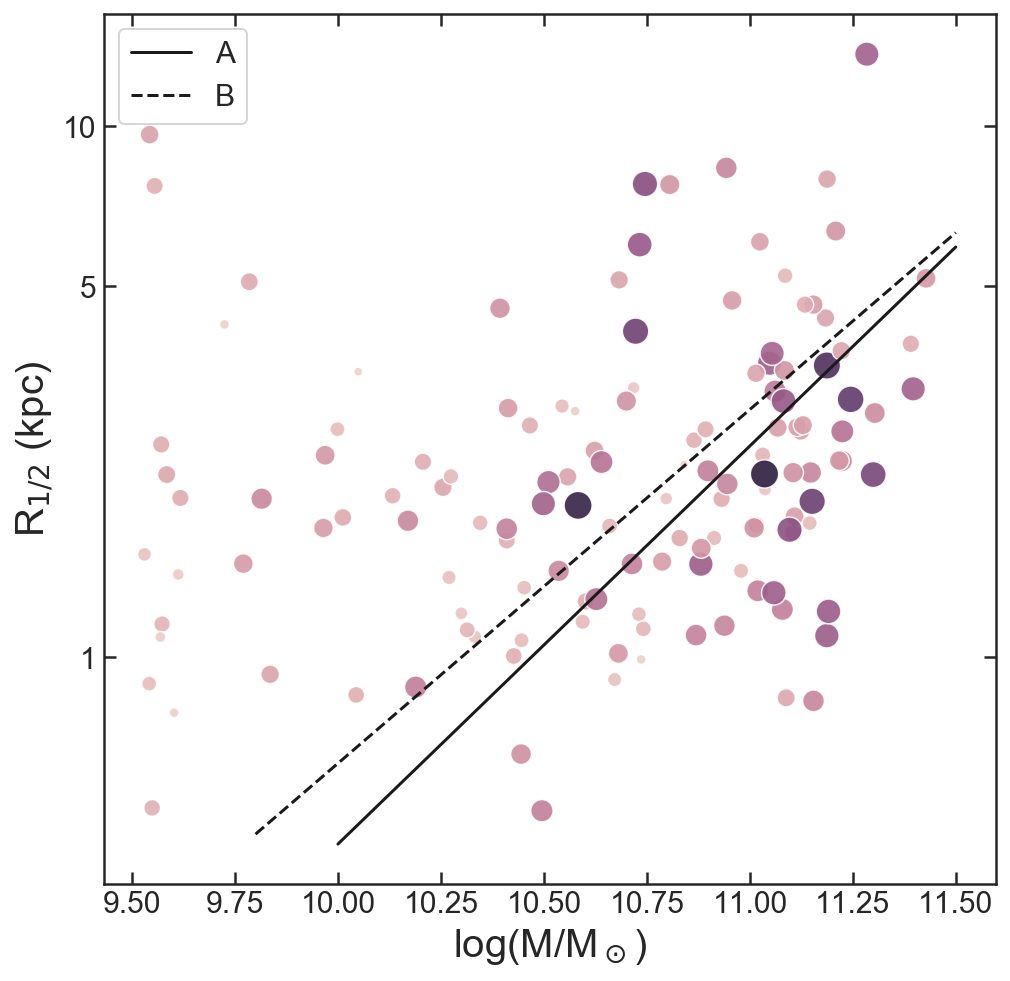

In [129]:
plt.figure(figsize=[8,8])
ax = plt.subplot()
    
sea.scatterplot(mdb.lmass, np.log10(mdb.Reff), color = '#507678',
                hue = mdb.z_50, size=np.log10(mdb.z_50),
                sizes=(20, 200),legend=False, ax=ax, alpha = 0.9)
    
masses = np.logspace(10,11.5)
Reffs = 2.5 * (masses / 1E11)**0.75
plt.plot(np.log10(masses),np.log10(Reffs),'k', label='A')

masses = np.logspace(9.8,11.5)
Reffs =(masses / 10**10.3)**(1/1.5)
plt.plot(np.log10(masses),np.log10(Reffs),'k--', label='B')
    
plt.yticks([np.log10(1),np.log10(5),np.log10(10)],[1,5,10])
# plt.xlim(9.4,11.5)
plt.legend(fontsize=15)
plt.ylabel('R$_{1/2}$ (kpc)', fontsize=20)
plt.xlabel('log(M/M$_\odot$)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('../plots/r_lm.png', bbox_inches = 'tight')

In [72]:
mrange = np.linspace(min(mdb.lmass),max(mdb.lmass),8)
rrange = np.linspace(min(np.log10(mdb.Reff)),max(np.log10(mdb.Reff)),8)
ms = [] 
rs = []
zs = []


for i in range(len(mrange)-1):
    for ii in range(len(rrange)-1):
        inrange = []
        for iii in mdb.index:
            if mrange[i] <= mdb.lmass[iii] <=mrange[i+1] and rrange[ii] <= np.log10(mdb.Reff[iii]) <=rrange[ii+1]:
                inrange.append(mdb.z_50[iii])
        if len(inrange) > 1:
            ms.append((mrange[i] + mrange[i+1])/2)
            rs.append((rrange[ii] + rrange[ii+1])/2)
            zs.append(max(inrange) - min(inrange))

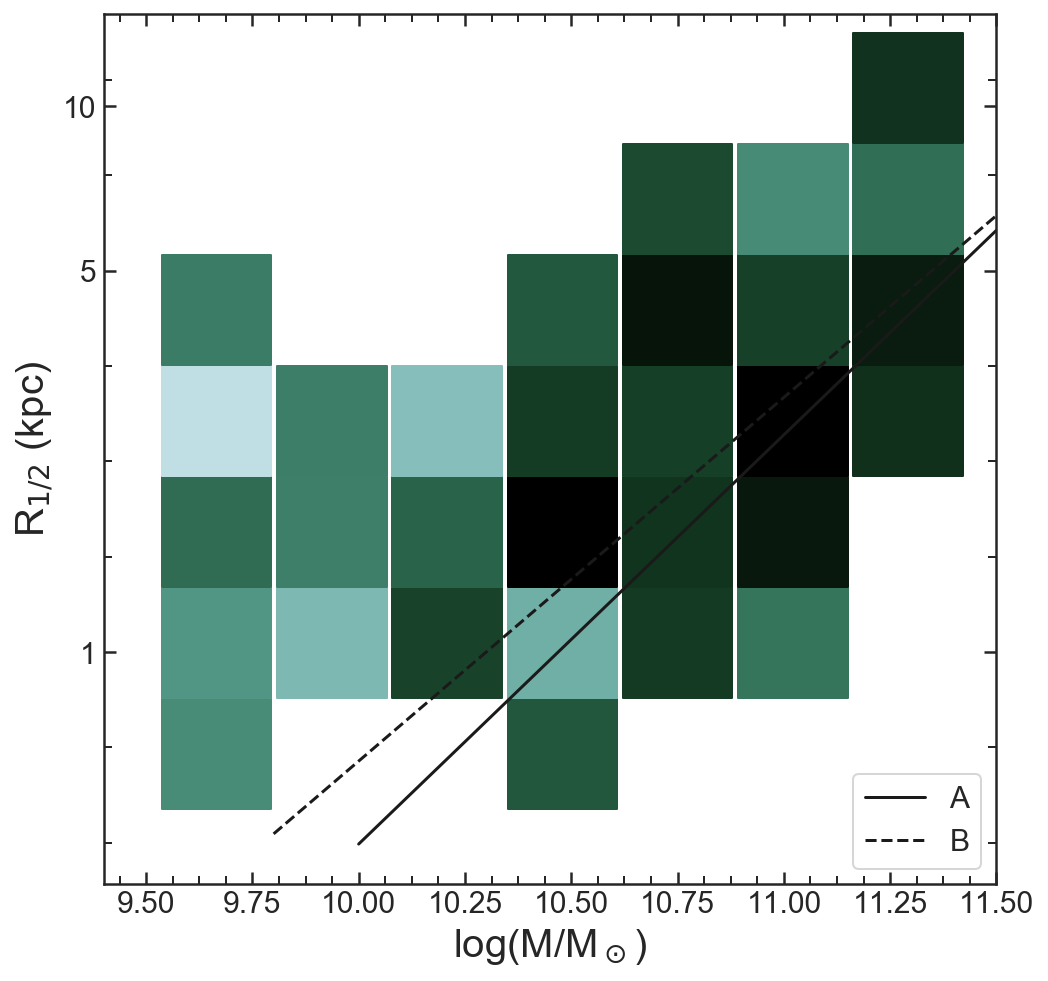

In [73]:
plt.figure(figsize=[8,8])
ax = plt.subplot()

plt.scatter(ms,rs,c=np.log10(zs), marker = 's', s = 3000,cmap=cmap)

    
# sea.scatterplot(mdb.lmass, np.log10(mdb.Reff), color = '#507678',
#                 hue = mdb.z_50, size=np.log10(mdb.z_50),
#                 sizes=(20, 200),legend=False, ax=ax, alpha = 0.9)

masses = np.logspace(10,11.5)
Reffs = 2.5 * (masses / 1E11)**0.75
plt.plot(np.log10(masses),np.log10(Reffs),'k', label='A')

masses = np.logspace(9.8,11.5)
Reffs =(masses / 10**10.3)**(1/1.5)
plt.plot(np.log10(masses),np.log10(Reffs),'k--', label='B')
    
plt.yticks([np.log10(1),np.log10(5),np.log10(10)],[1,5,10])
plt.xlim(9.4,11.5)
plt.legend(fontsize=15, loc=4)
plt.ylabel('R$_{1/2}$ (kpc)', fontsize=20)
plt.xlabel('log(M/M$_\odot$)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)


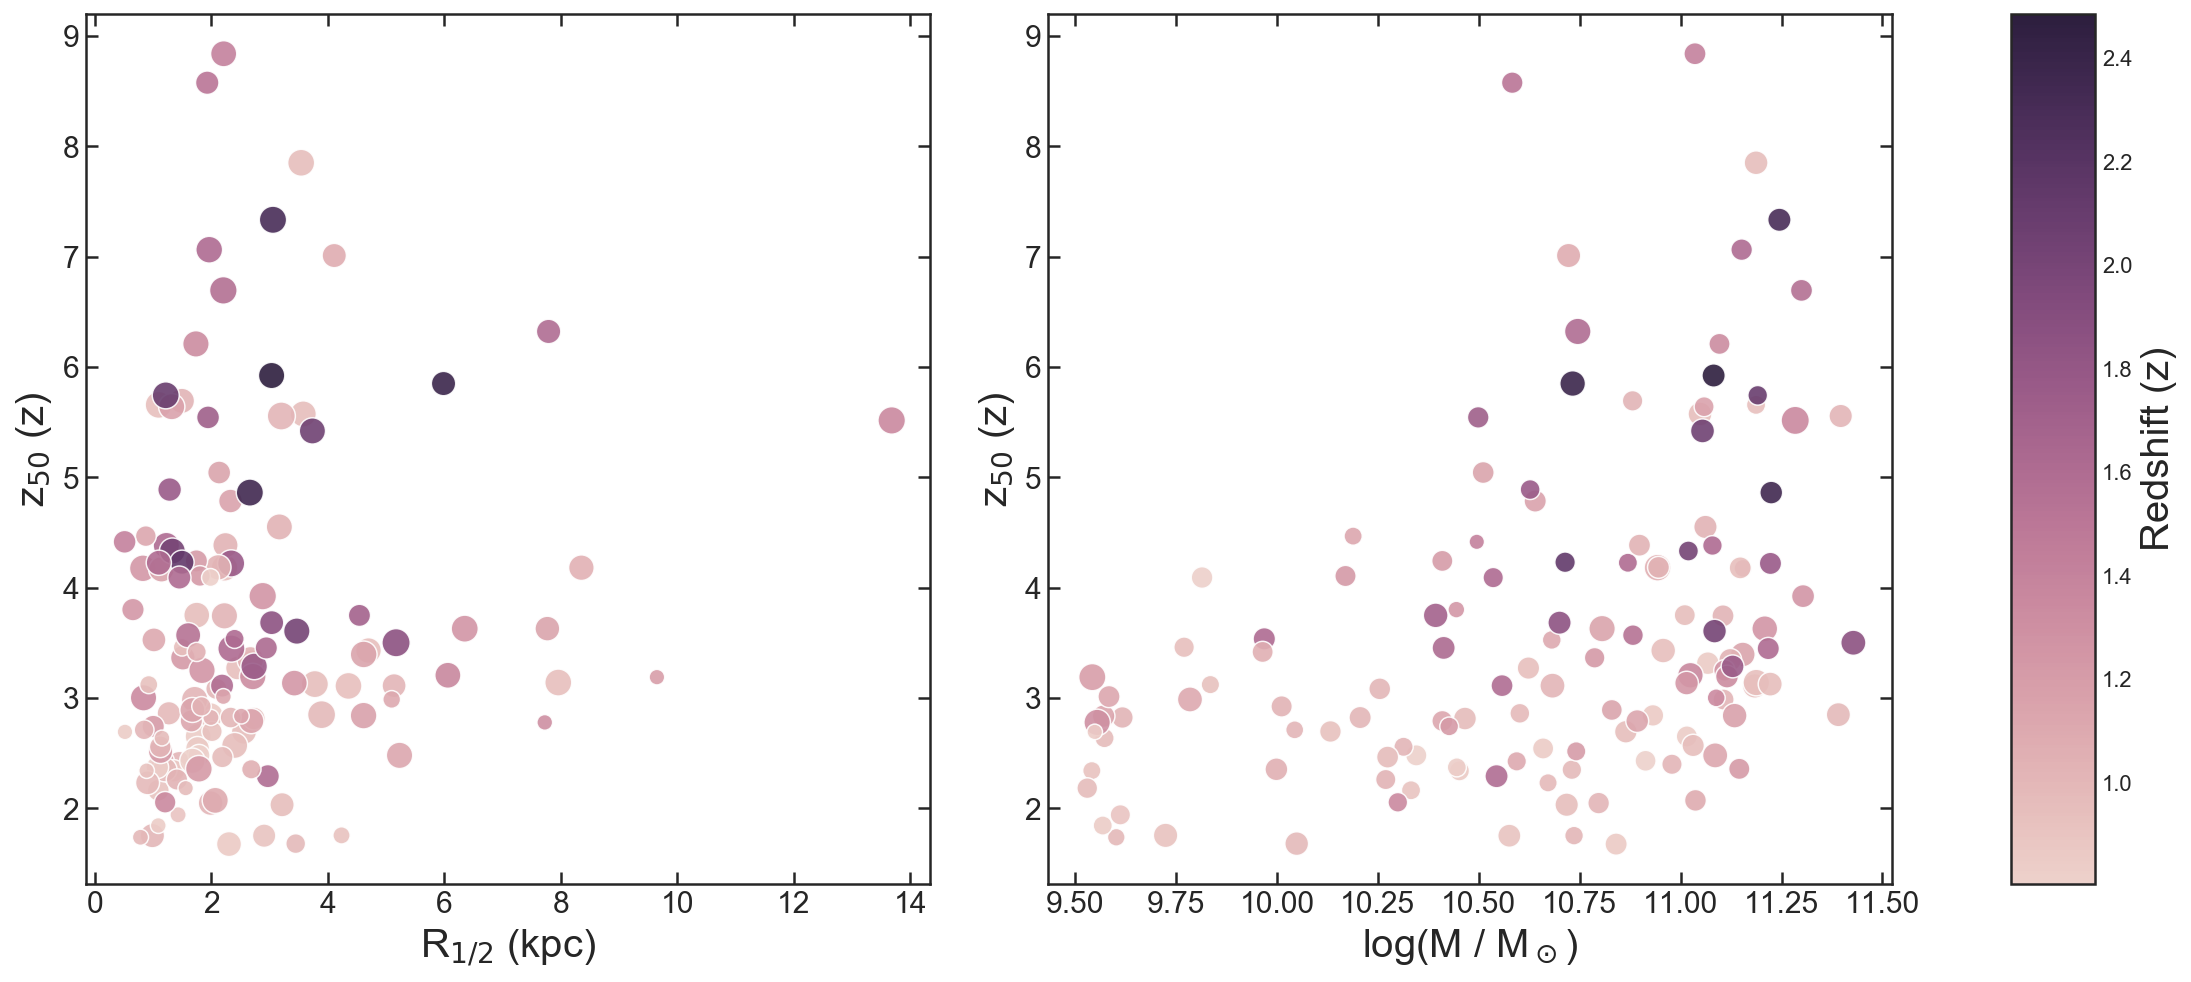

In [130]:
gs = gridspec.GridSpec(1,3,width_ratios=[1,1,.1])
plt.figure(figsize=[18,8])
ax1 = plt.subplot(gs[0])

sea.scatterplot(mdb.Reff, mdb.z_50, color = '#507678',
                size=mdb.lmass, hue=mdb.zgrism,sizes=(60, 200),legend=False, ax=ax1, alpha = 0.9)

# plt.ylim(0.8,10)

plt.xlabel('R$_{1/2}$ (kpc)', fontsize=20)
plt.ylabel('z$_{50}$ (z)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)

ax2 = plt.subplot(gs[1])
s2 = sea.scatterplot(mdb.lmass, mdb.z_50,
                size=np.log10(mdb.Reff), hue=mdb.zgrism,sizes=(60, 200),legend=False, ax=ax2, alpha = 0.9)
# plt.ylim(0.8,10)

plt.xlabel('log(M / M$_\odot$)', fontsize=20)
plt.ylabel('z$_{50}$ (z)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)

ax3 = plt.subplot(gs[2])
cmap = sea.cubehelix_palette(8, as_cmap=True)
norm = mpl.colors.Normalize(vmin=min(mdb.zgrism), vmax = max(mdb.zgrism))
mpl.colorbar.ColorbarBase(ax3, cmap = cmap, norm=norm, orientation='vertical')
ax3.set_ylabel('Redshift (z)', fontsize=20)
plt.savefig('../plots/z50_all.png', bbox_inches = 'tight')

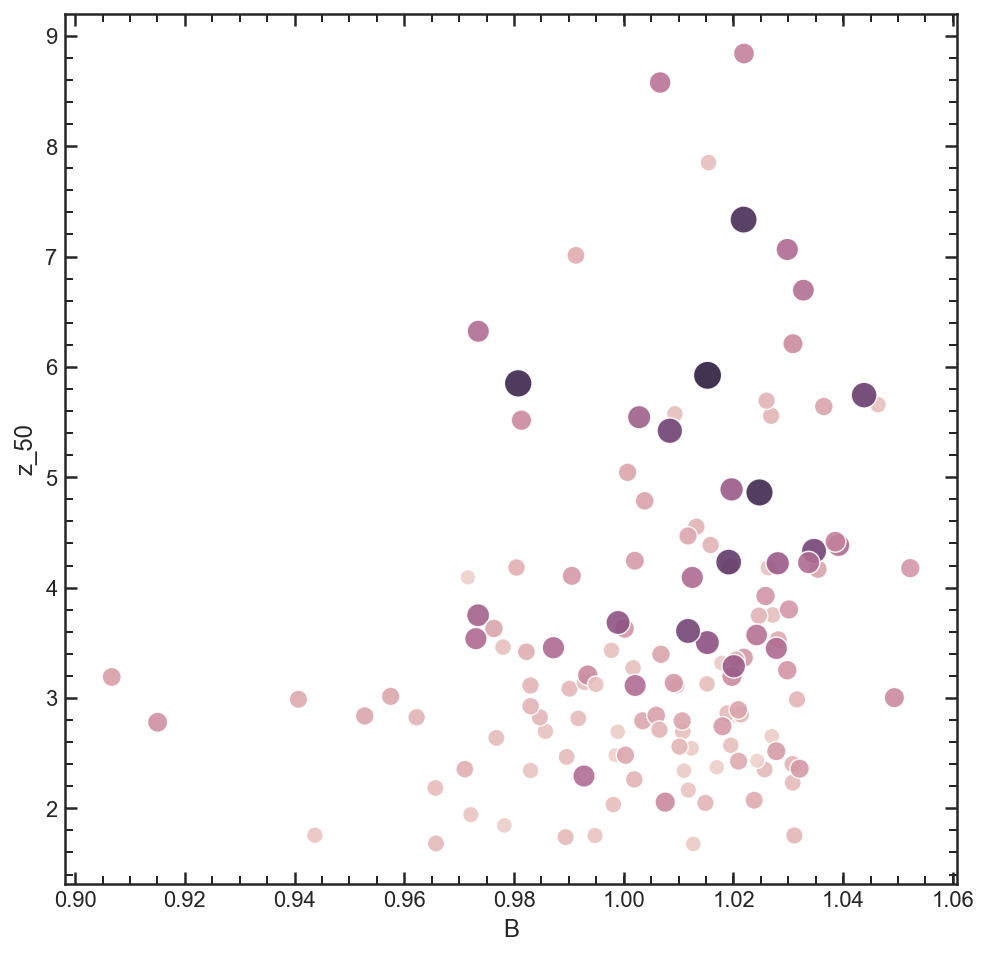

In [193]:
plt.figure(figsize=[8,8])
ax1 = plt.subplot()

sea.scatterplot(np.log10(mdb.B), mdb.z_50, color = '#507678',
                size=mdb.zgrism, hue=mdb.zgrism,sizes=(60, 200),legend=False, ax=ax1, alpha = 0.9)

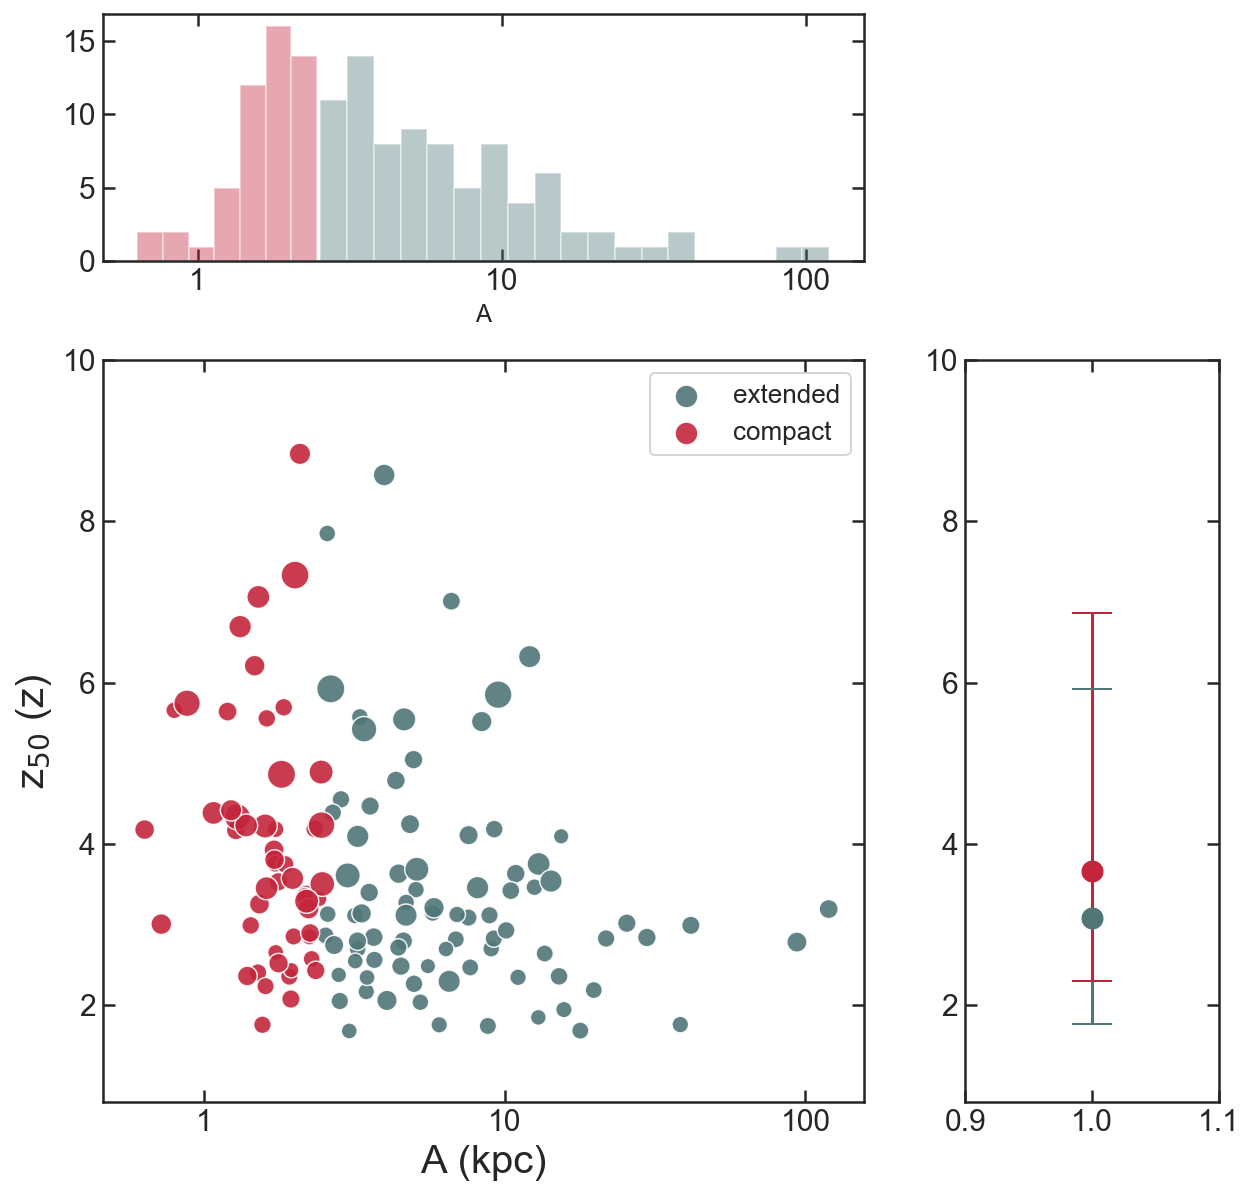

In [131]:
gs = gridspec.GridSpec(2,2,height_ratios=[1,3],width_ratios=[3,1])
plt.figure(figsize=[10,10])
ax1 = plt.subplot(gs[1,0])
sea.scatterplot(np.log10(mdb.query('compact_A == "e"').A), mdb.query('compact_A == "e"').z_50, color = '#507678',
                size=mdb.query('compact_A == "e"').zgrism,sizes=(60, 200),legend=False, ax=ax1, alpha = 0.9, label = 'extended')
sea.scatterplot(np.log10(mdb.query('compact_A == "c"').A), mdb.query('compact_A == "c"').z_50, color = '#C4253C', 
                size=mdb.query('compact_A == "c"').zgrism,sizes=(60, 200),legend=False, ax=ax1, alpha = 0.9, label = 'compact')

    
plt.ylim(0.8,10)
plt.xticks([np.log10(1),np.log10(10),np.log10(100)],[1,10,100])

plt.xlabel('A (kpc)', fontsize=20)
plt.ylabel('z$_{50}$ (z)', fontsize=20)
plt.legend(fontsize =13, frameon = True, loc = 1)
plt.tick_params(axis='both', which='major', labelsize=15)

ax2 = plt.subplot(gs[0,0])
sea.distplot(np.log10(mdb.query('compact_A == "e"').A), color = '#507678', kde = False, bins=19, ax = ax2)
sea.distplot(np.log10(mdb.query('compact_A == "c"').A), color = '#C4253C', kde = False, ax = ax2)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks([np.log10(1),np.log10(10),np.log10(100)],[1,10,100])

Cmdb = mdb.query('compact_A == "c"')
Emdb = mdb.query('compact_A == "e"')
ax3 = plt.subplot(gs[1,1])
plt.errorbar(1, np.percentile(Emdb.z_50,50), 
             yerr=[[np.percentile(Emdb.z_50,50) - np.percentile(Emdb.z_50,5)],
                   [np.percentile(Emdb.z_50,95) - np.percentile(Emdb.z_50,50)]],
            markersize = 10, marker = 'o', capsize=10, color = '#507678')

plt.errorbar(1, np.percentile(Cmdb.z_50,50), 
             yerr=[[np.percentile(Cmdb.z_50,50) - np.percentile(Cmdb.z_50,5)],
                   [np.percentile(Cmdb.z_50,95) - np.percentile(Cmdb.z_50,50)]],
            markersize = 10, marker = 'o', capsize=10, color = '#C4253C')
plt.ylim(0.8,10)
ax3.set_xlim(0.9,1.1)

plt.tick_params(axis='both', which='major', labelsize=15)

plt.savefig('../plots/compact_a.png', bbox_inches = 'tight')

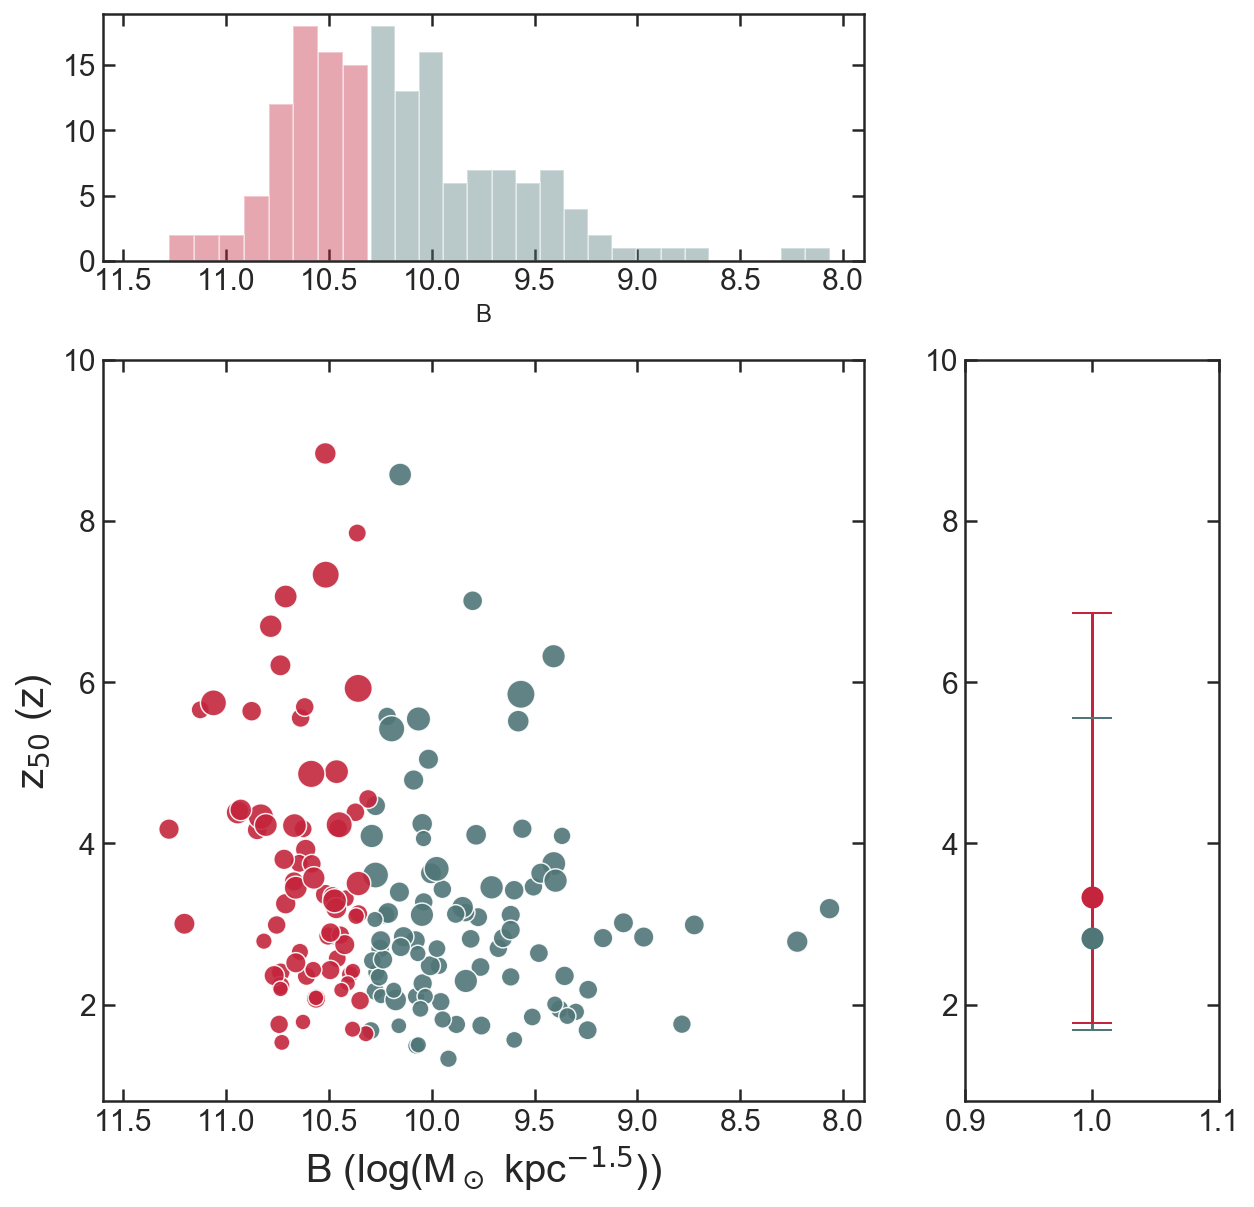

In [178]:
gs = gridspec.GridSpec(2,2,height_ratios=[1,3],width_ratios=[3,1])
plt.figure(figsize=[10,10])
ax1 = plt.subplot(gs[1,0])
sea.scatterplot(mdb.query('compact_B == "e"').B, mdb.query('compact_B == "e"').z_50, color = '#507678', 
                size=mdb.query('compact_B == "e"').zgrism,sizes=(60, 200),legend=False, ax=ax1, alpha = 0.9, label = 'extended')
sea.scatterplot(mdb.query('compact_B == "c"').B, mdb.query('compact_B == "c"').z_50, color = '#C4253C', 
                size=mdb.query('compact_B == "c"').zgrism,sizes=(60, 200),legend=False, ax=ax1, alpha = 0.9, label = 'compact')
plt.ylim(0.8,10)
plt.xlim(11.6,7.9)

plt.xlabel('B (log(M$_\odot$ kpc$^{-1.5}$))', fontsize=20)
plt.ylabel('z$_{50}$ (z)', fontsize=20)
# plt.legend(fontsize =13, frameon = True, loc = 1)
plt.tick_params(axis='both', which='major', labelsize=15)

ax2 = plt.subplot(gs[0,0])
sea.distplot(mdb.query('compact_B == "e"').B, color = '#507678', kde = False, bins=19, ax = ax2)
sea.distplot(mdb.query('compact_B == "c"').B, color = '#C4253C', kde = False, ax = ax2)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(11.6,7.9)


Cmdb = mdb.query('compact_B == "c"')
Emdb = mdb.query('compact_B == "e"')
ax3 = plt.subplot(gs[1,1])
plt.errorbar(1, np.percentile(Emdb.z_50,50), 
             yerr=[[np.percentile(Emdb.z_50,50) - np.percentile(Emdb.z_50,5)],
                   [np.percentile(Emdb.z_50,95) - np.percentile(Emdb.z_50,50)]],
            markersize = 10, marker = 'o', capsize=10, color = '#507678')

plt.errorbar(1, np.percentile(Cmdb.z_50,50), 
             yerr=[[np.percentile(Cmdb.z_50,50) - np.percentile(Cmdb.z_50,5)],
                   [np.percentile(Cmdb.z_50,95) - np.percentile(Cmdb.z_50,50)]],
            markersize = 10, marker = 'o', capsize=10, color = '#C4253C')
plt.ylim(0.8,10)
ax3.set_xlim(0.9,1.1)
plt.ylim(0.8,10)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.savefig('../plots/compact_b.png', bbox_inches = 'tight')

In [151]:
zllim = [0.8, 0.94, 1.02, 1.2, 1.55]
zhlim = [0.94, 1.02, 1.2, 1.55, 2.5]


for i in range(len(colors)):
    vals = []
    for ii in mdb.index:
        if zllim[i] <= mdb.zgrism[ii] <zhlim[i]:
            vals.append(mdb.z_50[ii])
    print(len(vals))

24
29
32
23
27


24
29
32
23
27


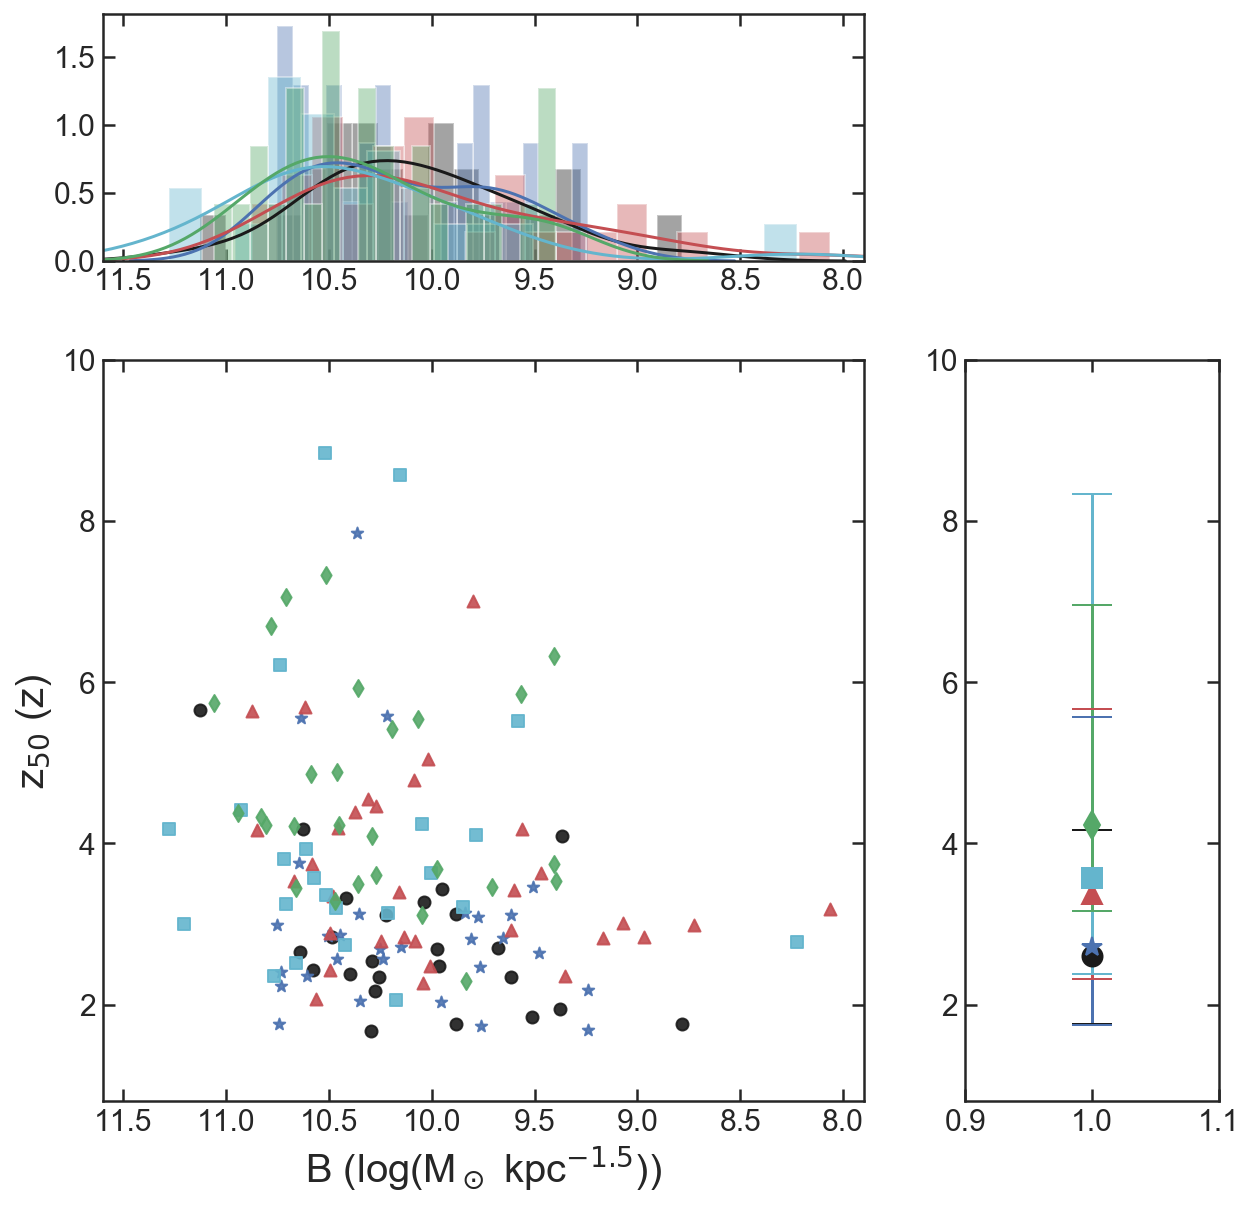

In [152]:
gs = gridspec.GridSpec(2,2,height_ratios=[1,3],width_ratios=[3,1])

colors = ['k','b','r','c','g']
markers = ['o','*','^','s','d']
zllim = [0.8, 0.94, 1.02, 1.2, 1.55]
zhlim = [0.94, 1.02, 1.2, 1.55, 2.5]


plt.figure(figsize=[10,10])
ax1 = plt.subplot(gs[1,0])

for i in range(len(colors)):
    for ii in mdb.index:
        if zllim[i] <= mdb.zgrism[ii] <zhlim[i]:
            plt.scatter(mdb.B[ii], mdb.z_50[ii], color = colors[i], marker=markers[i],
                            alpha = 0.9)

plt.ylim(0.8,10)
plt.xlim(11.6,7.9)

plt.xlabel('B (log(M$_\odot$ kpc$^{-1.5}$))', fontsize=20)
plt.ylabel('z$_{50}$ (z)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)

ax2 = plt.subplot(gs[0,0])

for i in range(len(colors)):
    vals = []
    for ii in mdb.index:
        if zllim[i] <= mdb.zgrism[ii] <zhlim[i]:
            vals.append(mdb.B[ii])
    sea.distplot(vals, color = colors[i], kde = True, bins=19, ax = ax2)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(11.6,7.9)


ax3 = plt.subplot(gs[1,1])
for i in range(len(colors)):
    vals = []
    for ii in mdb.index:
        if zllim[i] <= mdb.zgrism[ii] <zhlim[i]:
            vals.append(mdb.z_50[ii])

    plt.errorbar(1, np.percentile(vals,50), 
                 yerr=[[np.percentile(vals,50) - np.percentile(vals,5)],
                       [np.percentile(vals,95) - np.percentile(vals,50)]],
                markersize = 10, marker = markers[i], capsize=10, color = colors[i])
    print(len(vals))
plt.ylim(0.8,10)
ax3.set_xlim(0.9,1.1)
plt.ylim(0.8,10)
zllim = [0.5,1.0,1.3,1.6,2.0]
plt.tick_params(axis='both', which='major', labelsize=15)

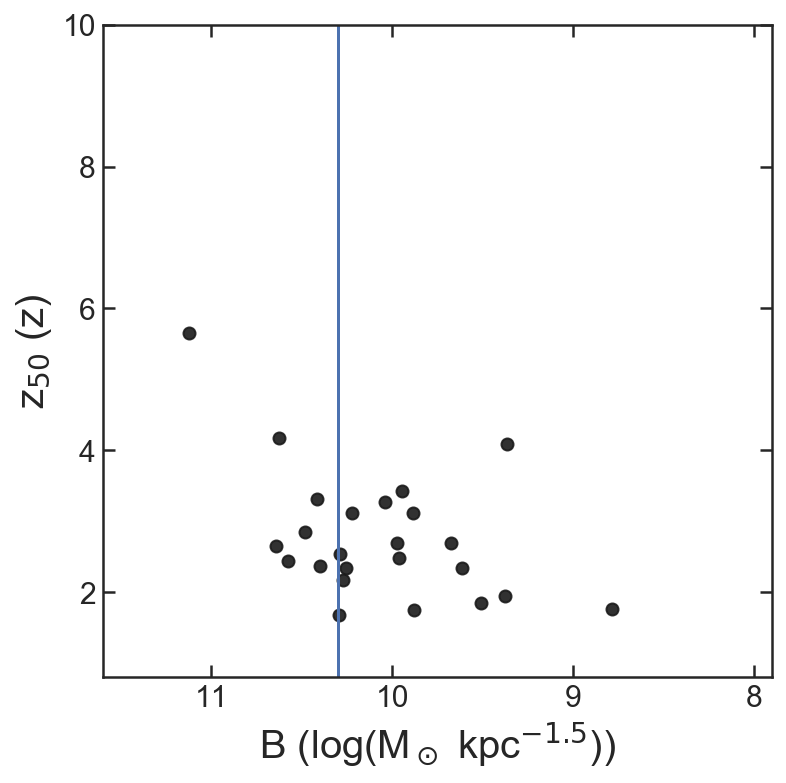

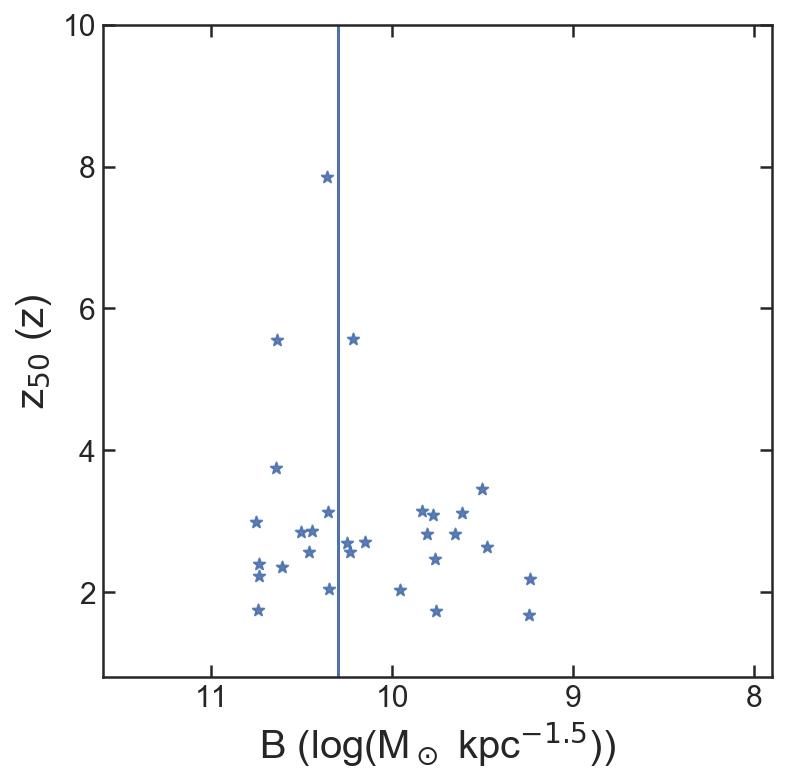

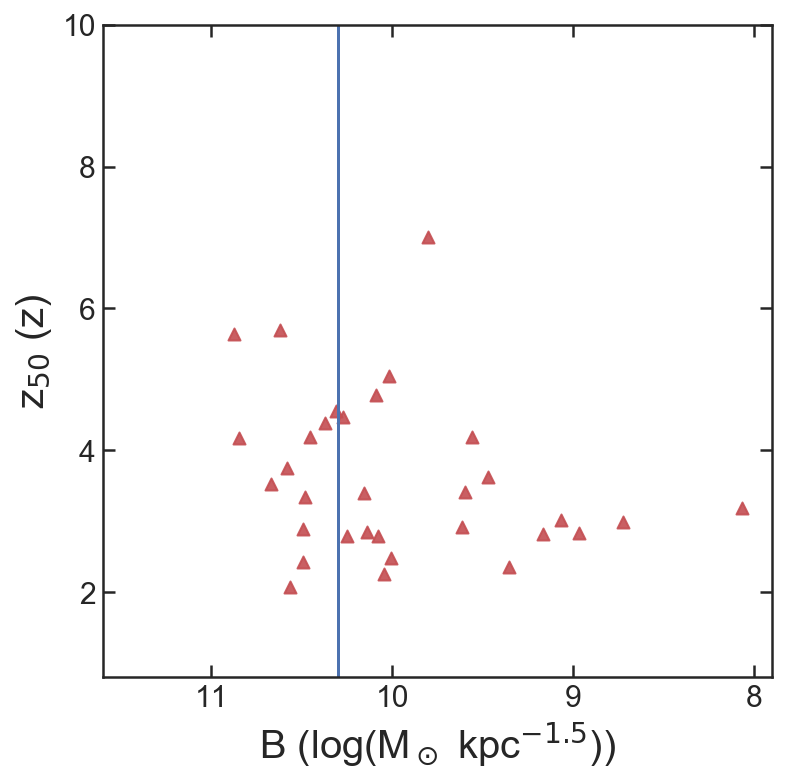

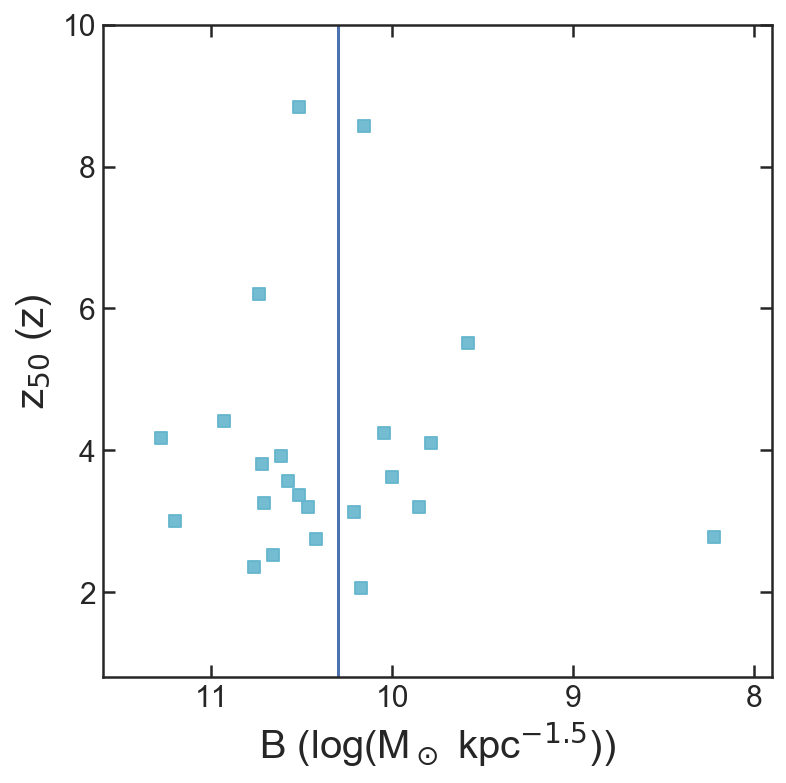

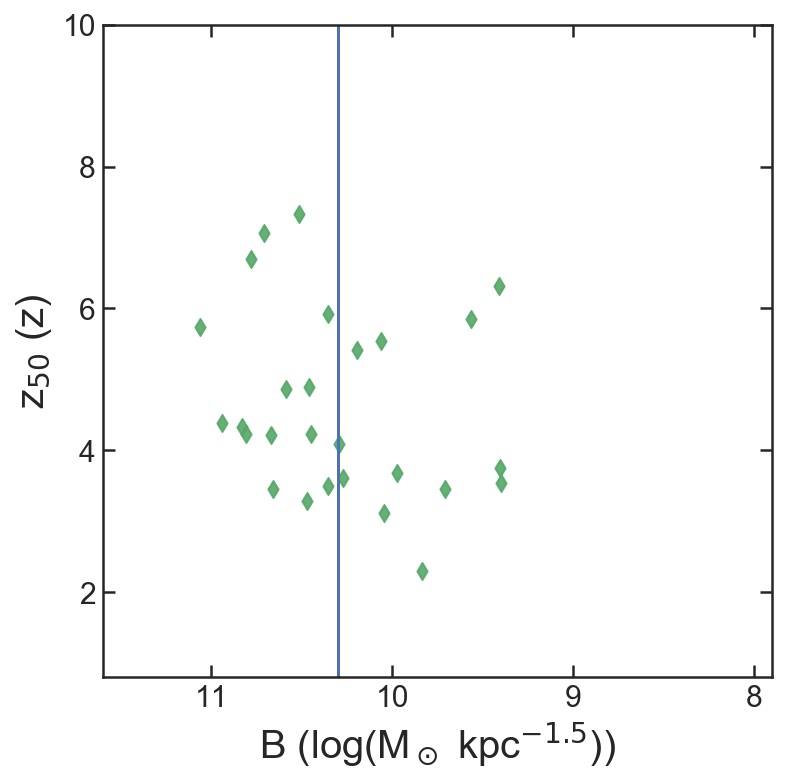

In [154]:
colors = ['k','b','r','c','g']
markers = ['o','*','^','s','d']
zllim = [0.8, 0.94, 1.02, 1.2, 1.55]
zhlim = [0.94, 1.02, 1.2, 1.55, 2.5]

for i in range(len(colors)):
    plt.figure(figsize=[6,6])

    for ii in mdb.index:
        if zllim[i] <= mdb.zgrism[ii] <zhlim[i]:
            plt.scatter(mdb.B[ii], mdb.z_50[ii], color = colors[i], marker=markers[i],
                            alpha = 0.9)
    plt.axvline(10.3)   
    plt.ylim(0.8,10)
    plt.xlim(11.6,7.9)

    plt.xlabel('B (log(M$_\odot$ kpc$^{-1.5}$))', fontsize=20)
    plt.ylabel('z$_{50}$ (z)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

(0, 9)

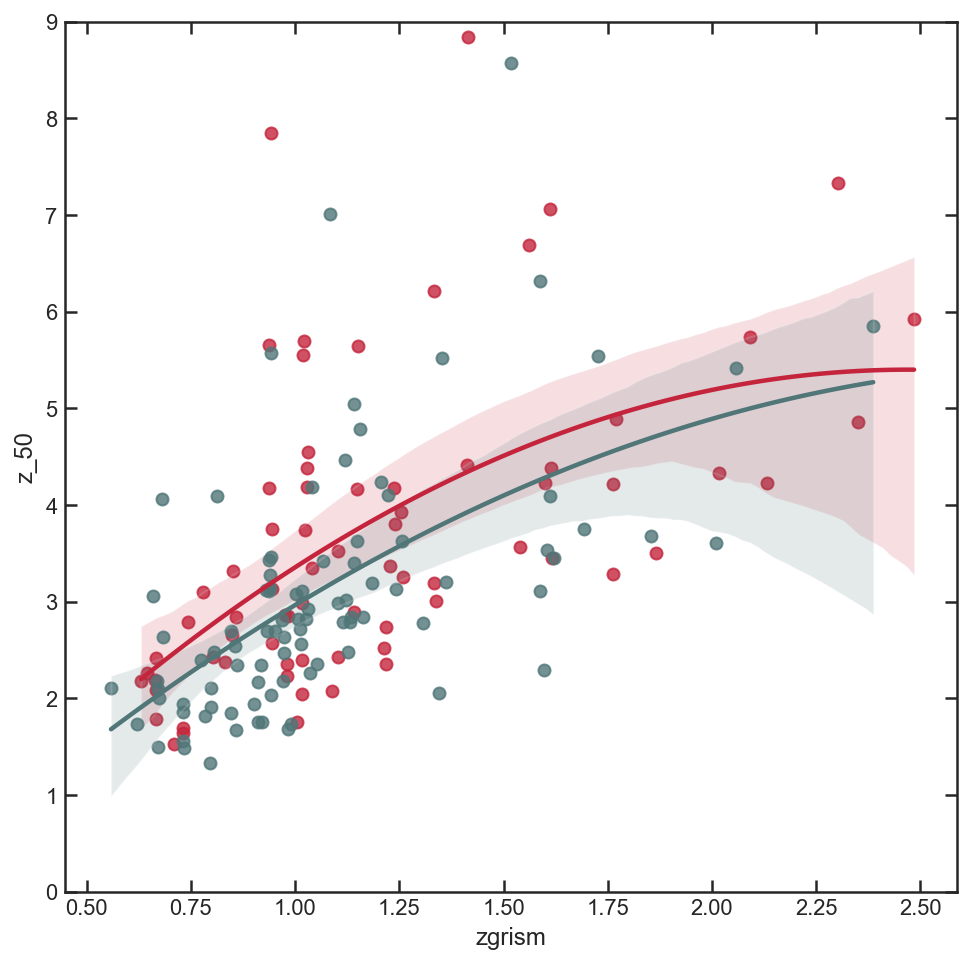

In [199]:
plt.figure(figsize=[8,8])
ax = plt.subplot()
sea.regplot(Cmdb.zgrism, Cmdb.z_50, color = '#C4253C',truncate = True, order = 2)
sea.regplot(Emdb.zgrism, Emdb.z_50, color = '#507678',truncate = True, order = 2)
ax.set_ylim(0,9)

(0, 6)

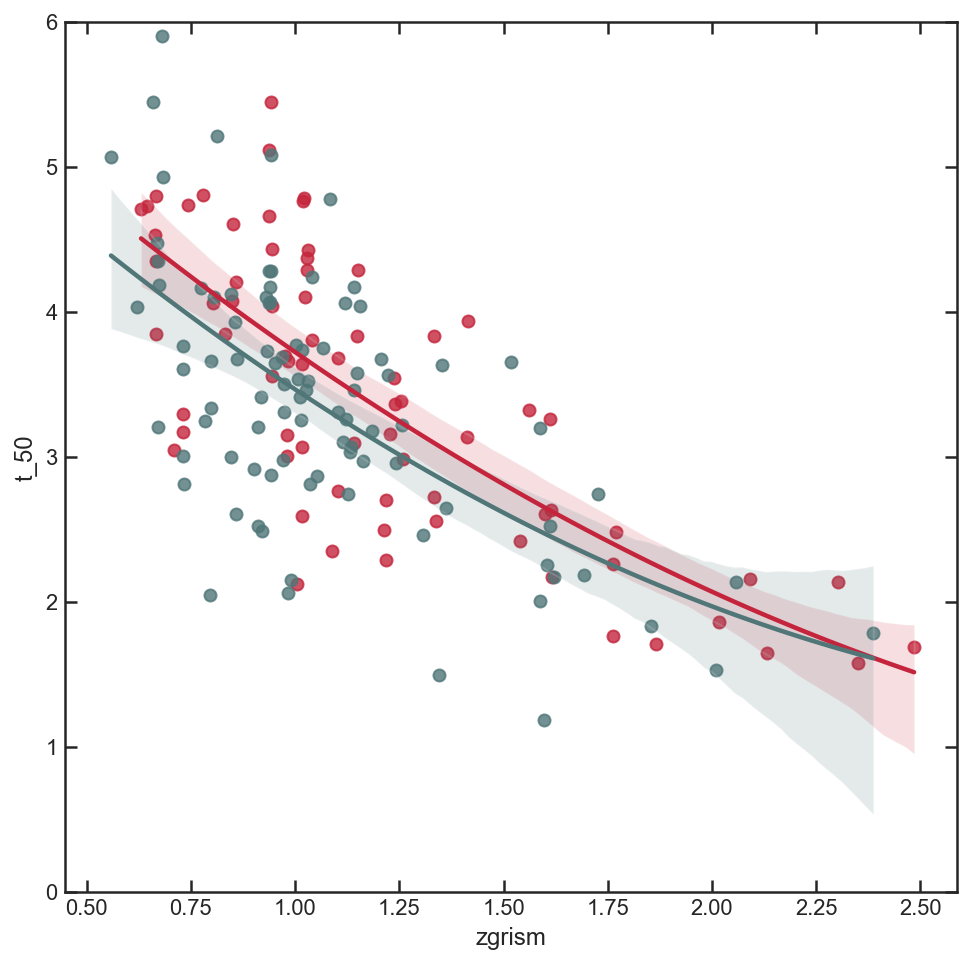

In [183]:
plt.figure(figsize=[8,8])
ax = plt.subplot()
sea.regplot(Cmdb.zgrism, Cmdb.t_50,order=2, color = '#C4253C',truncate=True)
sea.regplot(Emdb.zgrism, Emdb.t_50,order=2, color = '#507678',truncate=True)
ax.set_ylim(0,6)

([], <a list of 0 Text xticklabel objects>)

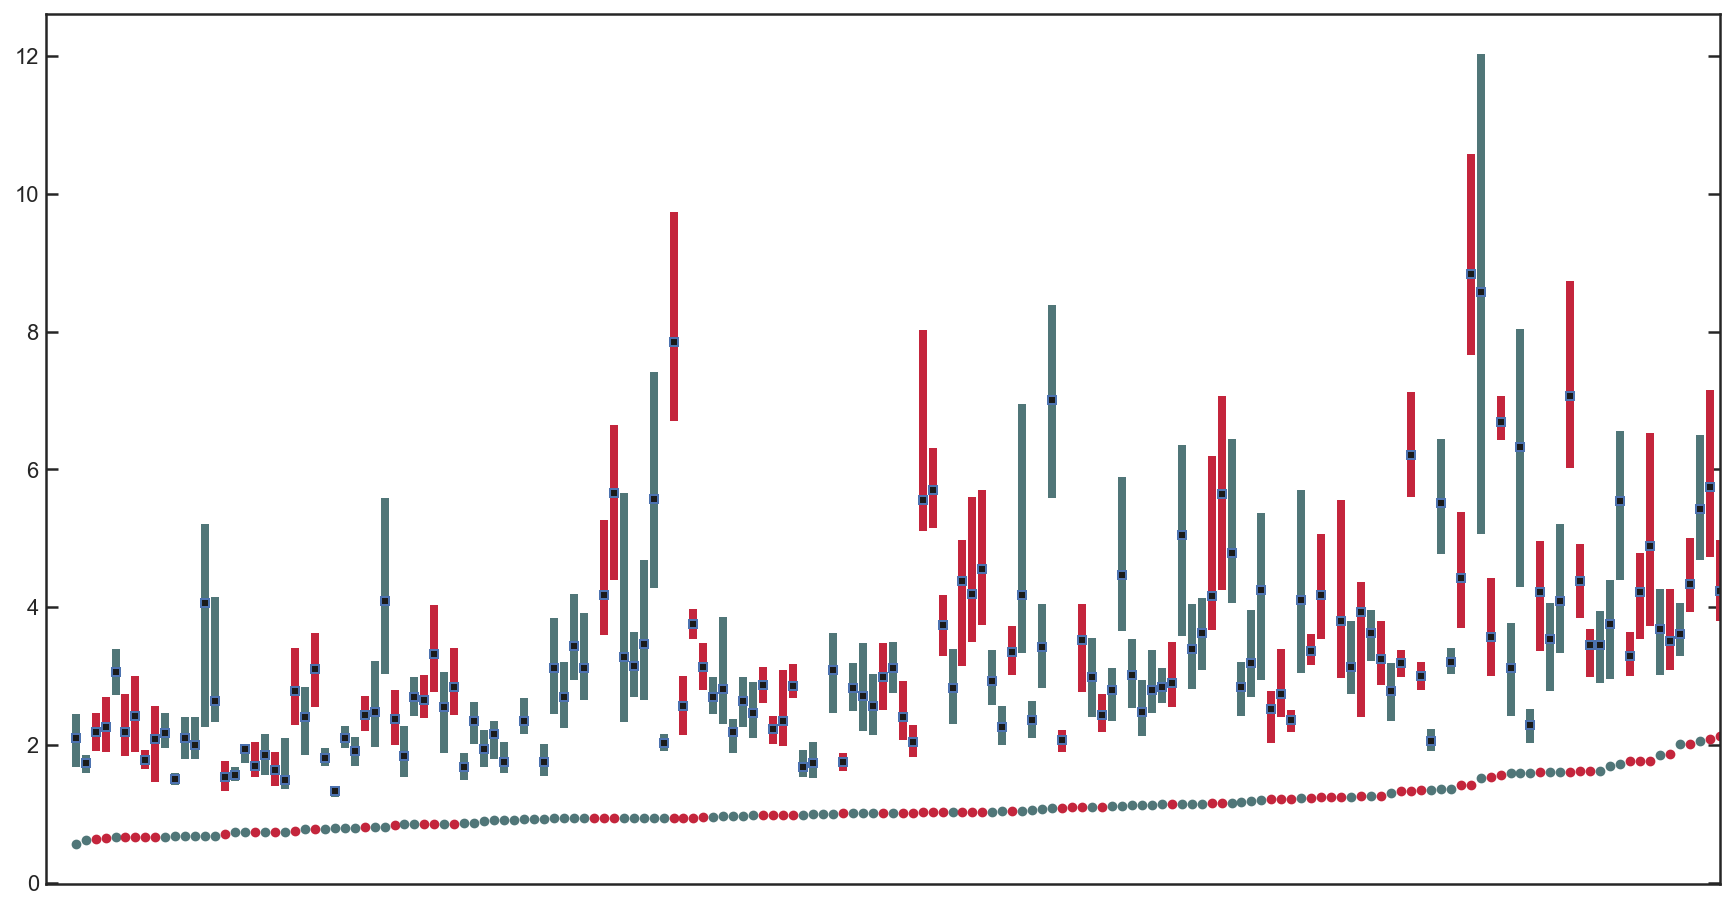

In [257]:
idx = 0
plt.figure(figsize=[15,8])
ax = plt.subplot()
for i in mdb.sort_values('zgrism').index:
    for ii in range(len(mdb.z_50_hci[i])//2):
        if mdb.B[i] > 10.3:
            mr = 'o'
            cr = '#C4253C'
        else:
            mr = 'o'
            cr = '#507678'
                
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1]:
            plt.errorbar([idx],mdb.z_50[i], yerr=[[mdb.z_50[i] - mdb.z_50_hci[i][2*ii]], 
                        [mdb.z_50_hci[i][2*ii+1] - mdb.z_50[i]]],marker = 's', mfc= 'k', elinewidth = 4, ecolor = cr, markersize=4)
                
        plt.scatter([idx],mdb.zgrism[i], marker = mr, color = cr, s=15)
    
    
    
        idx += 1 
plt.xlim(-3,165)
plt.xticks([])

(0, 12)

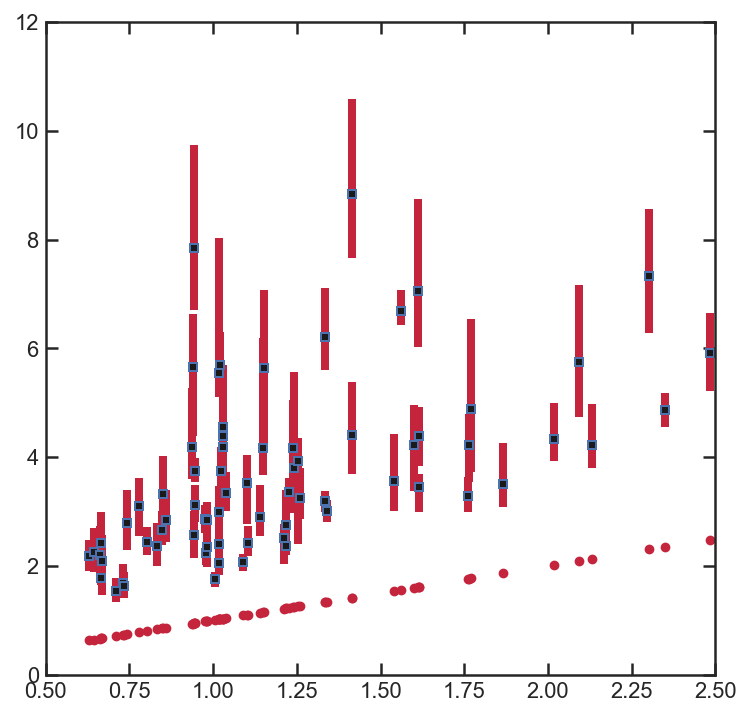

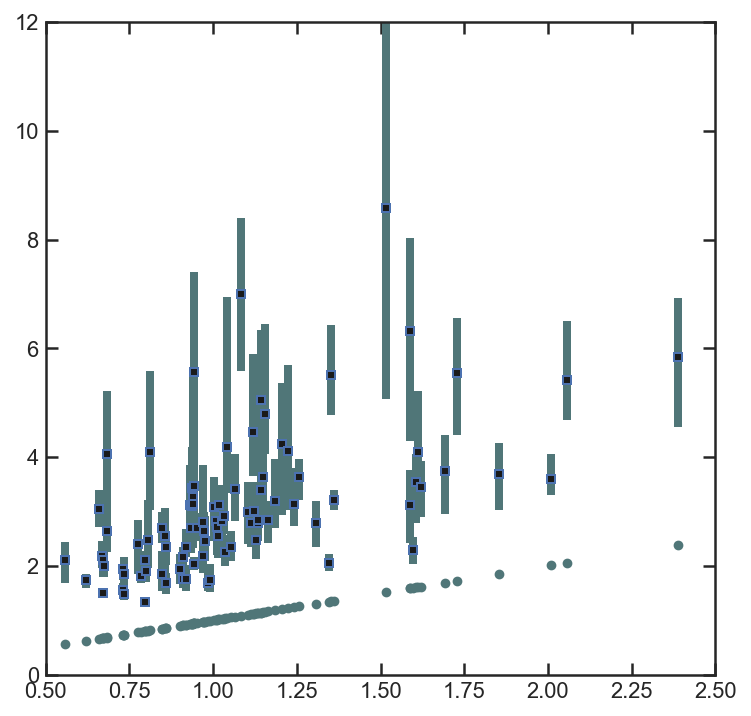

In [263]:
plt.figure(figsize=[6,6])
ax = plt.subplot()
for i in mdb.sort_values('zgrism').index:
    for ii in range(len(mdb.z_50_hci[i])//2):
        mr = 'o'
        cr = '#C4253C'
                
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1] and mdb.B[i] > 10.3:
            plt.errorbar(mdb.zgrism[i],mdb.z_50[i], yerr=[[mdb.z_50[i] - mdb.z_50_hci[i][2*ii]], 
                        [mdb.z_50_hci[i][2*ii+1] - mdb.z_50[i]]],marker = 's', mfc= 'k', elinewidth = 4, ecolor = cr, markersize=4)
                
            plt.scatter(mdb.zgrism[i],mdb.zgrism[i], marker = mr, color = cr, s=15)

plt.xlim(0.5,2.5)
plt.ylim(0,12)

plt.figure(figsize=[6,6])
ax = plt.subplot()
for i in mdb.sort_values('zgrism').index:
    for ii in range(len(mdb.z_50_hci[i])//2):

        mr = 'o'
        cr = '#507678'
                
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1] and mdb.B[i] < 10.3 :
            plt.errorbar(mdb.zgrism[i],mdb.z_50[i], yerr=[[mdb.z_50[i] - mdb.z_50_hci[i][2*ii]], 
                        [mdb.z_50_hci[i][2*ii+1] - mdb.z_50[i]]],marker = 's', mfc= 'k', elinewidth = 4, ecolor = cr, markersize=4)
                
            plt.scatter(mdb.zgrism[i],mdb.zgrism[i], marker = mr, color = cr, s=15)
plt.xlim(0.5,2.5)
plt.ylim(0,12)

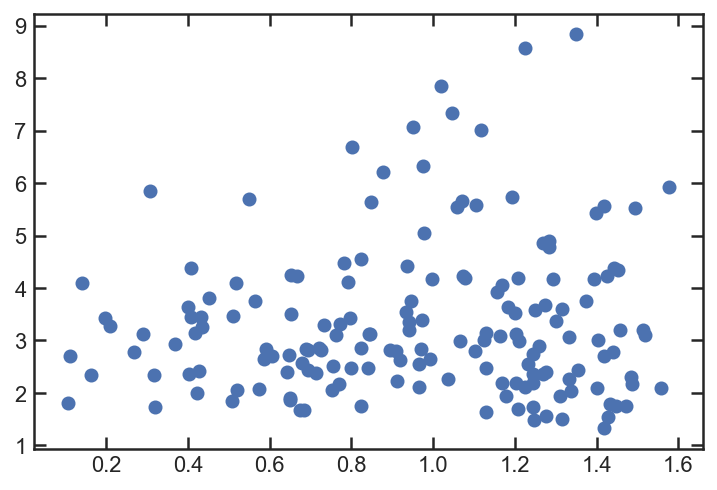

In [222]:
plt.scatter(mdb.Z, mdb.z_50)

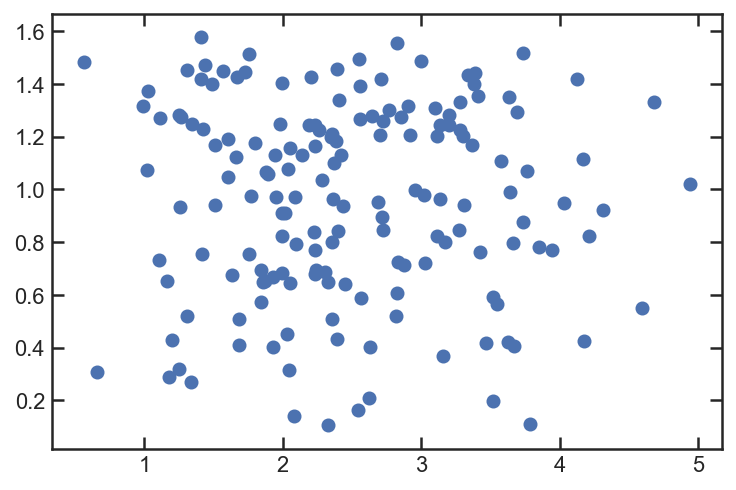

In [229]:
plt.scatter(mdb.lwa, mdb.Z)

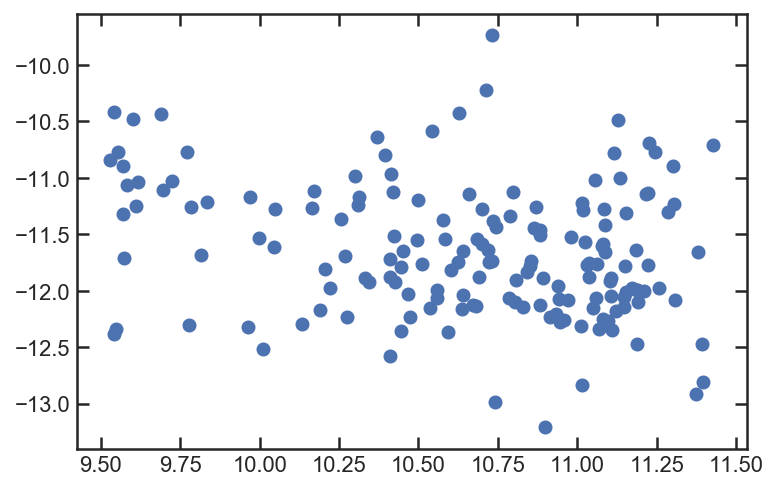

In [237]:
plt.scatter(mdb.lmass, mdb.log_ssfr)

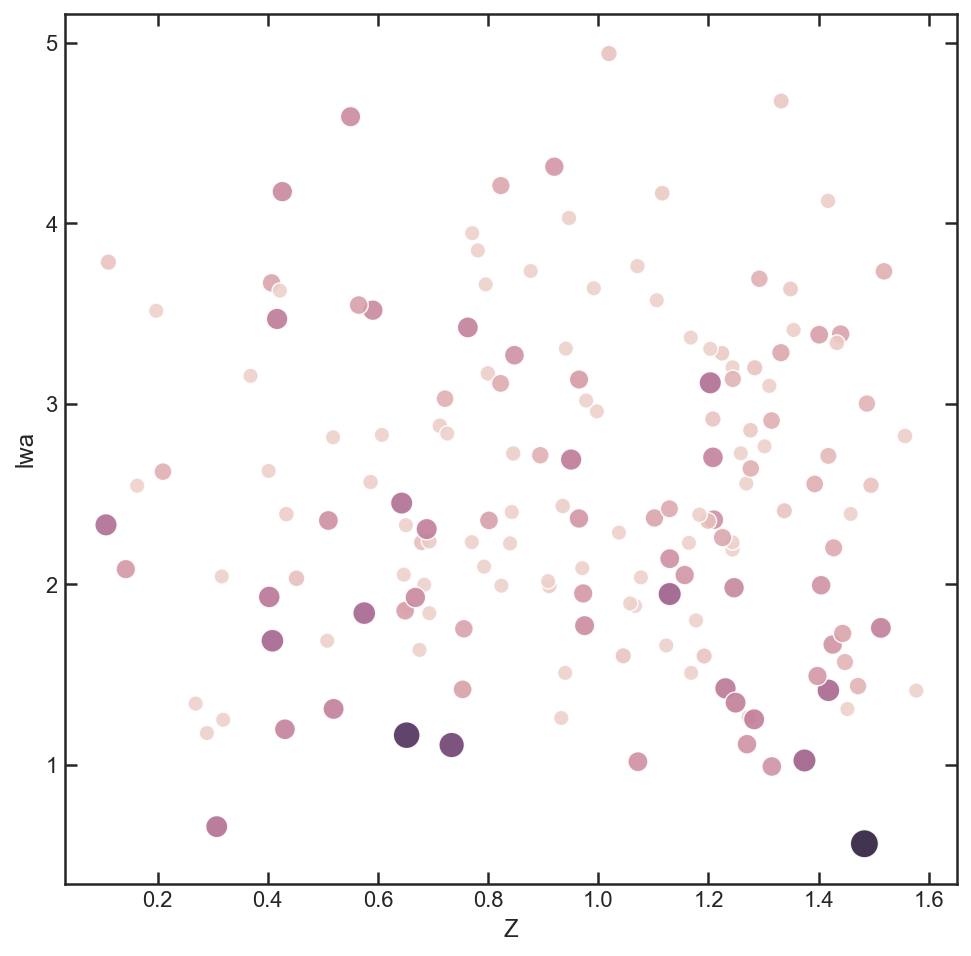

In [230]:
plt.figure(figsize=[8,8])
ax1 = plt.subplot()

sea.scatterplot(mdb.Z, mdb.lwa, color = '#507678',
                size=mdb.Av, hue=mdb.Av,sizes=(60, 200),legend=False, ax=ax1, alpha = 0.9)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(0, 8)

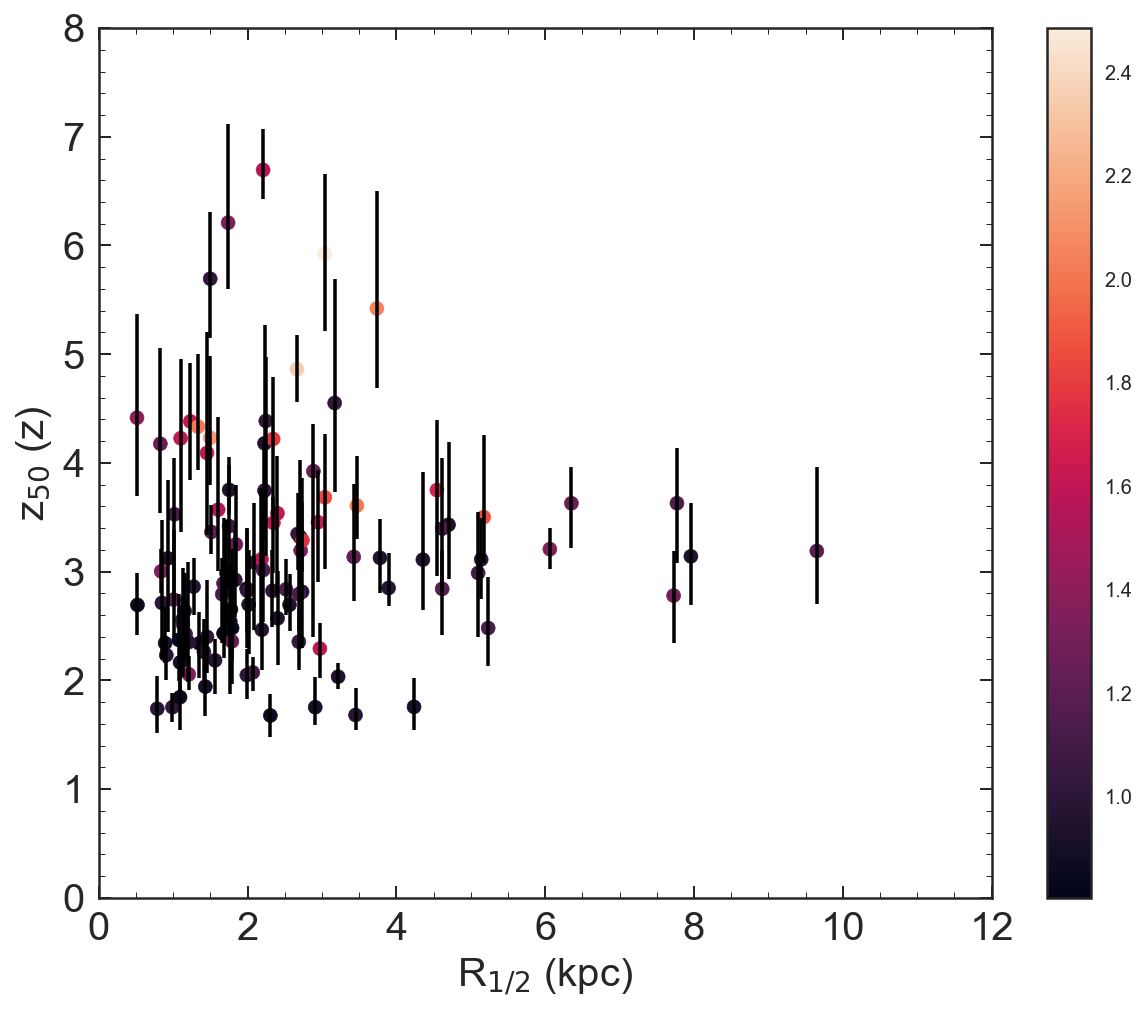

In [67]:
morph_db = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')
mdb = morph_db.query('zgrism > 0.8 and log_ssfr  > -15')
# mdb = morph_db.query('1.8 < zgrism < 2.2 and log_ssfr  > -15')

inout = []
for i in mdb.index:
    for ii in range(len(mdb.z_50_hci[i])//2):
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1]:
            if (mdb.z_50_hci[i][2*ii+1] - mdb.z_50_hci[i][2*ii]) /2  < 1:
                inout.append('i')
            else:
                inout.append('o')
        
mdb['inout'] = inout
mdb = mdb.query('inout == "i"')

plt.figure(figsize=[10,8])

for i in mdb.index:
    for ii in range(len(mdb.z_50_hci[i])//2):
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1]:
            plt.errorbar(mdb.Reff[i],mdb.z_50[i], 
                 yerr=[[mdb.z_50[i] - mdb.z_50_hci[i][2*ii]], [mdb.z_50_hci[i][2*ii+1] - mdb.z_50[i]]], fmt='ko',
                        markersize=1)
plt.scatter(mdb.Reff, mdb.z_50, marker='o', c = mdb.zgrism)

# plt.hexbin(mdb.Reff, mdb.z_50, cmap = cmap)
# plt.scatter(sfdb.Reff,sfdb.z50, marker = '*',c = sfdb.log_ssfr, s =100)
plt.colorbar()

plt.xlabel('R$_{1/2}$ (kpc)', fontsize=20)
plt.ylabel('z$_{50}$ (z)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(0,12)
plt.ylim(0,8)
# plt.savefig('../plots/morph/z_50_r.png', bbox_inches = 'tight')

# plots for presentation

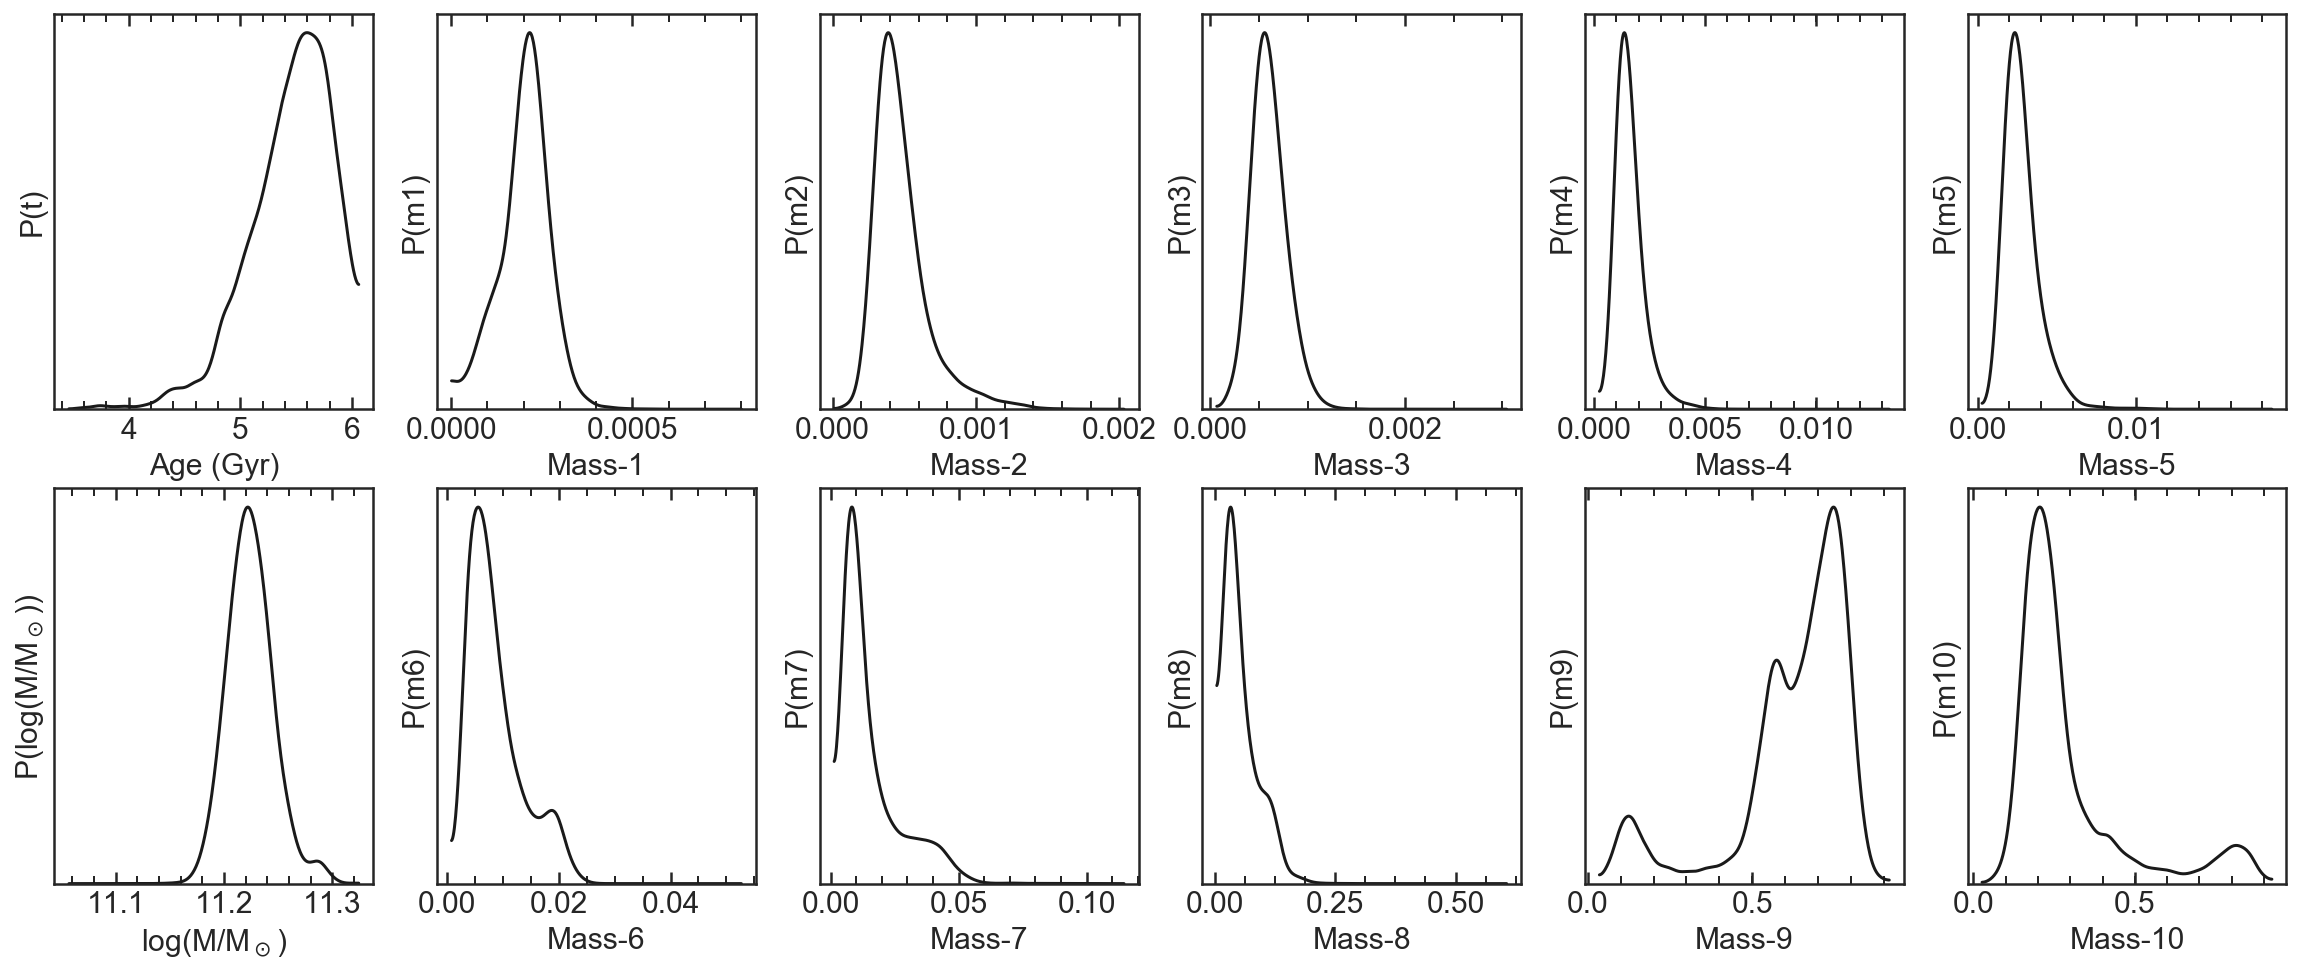

In [361]:
def plot_posterior(field, galaxy, param, x_name, y_name):
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_P{2}.npy'.format(field, galaxy, param))

    plt.plot(z,pz,'k')
    plt.xlabel('{0}'.format(x_name), fontsize=15)
    plt.ylabel('P({0})'.format(y_name), fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.ylim(0,max(pz)*1.05)
    plt.yticks([])

params = ['a', 'm1', 'm2', 'm3', 'm4', 'm5', 'lm', 'm6', 'm7', 'm8', 'm9', 'm10']
x_name = ['Age (Gyr)', 'Mass-1', 'Mass-2', 'Mass-3', 'Mass-4', 'Mass-5', 'log(M/M$_\odot$)', 'Mass-6', 'Mass-7', 'Mass-8', 'Mass-9', 
          'Mass-10']
y_name = ['t', 'm1', 'm2', 'm3', 'm4', 'm5', 'log(M/M$_\odot$)', 'm6', 'm7', 'm8', 'm9', 'm10']

gs = gridspec.GridSpec(2,6)
plt.figure(figsize=[20,8])

row = 0
col = 0
for i in range(len(params)):
    plt.subplot(gs[row, col])
    plot_posterior('GND', 37813, params[i], x_name[i], y_name[i])
    col += 1
    if i == 5:
        row =1 
        col = 0
plt.savefig('../plots/GND_37813_post.png',bbox_inches = 'tight')


In [3]:
sfh = Rescale_sfh('GND', 37813)

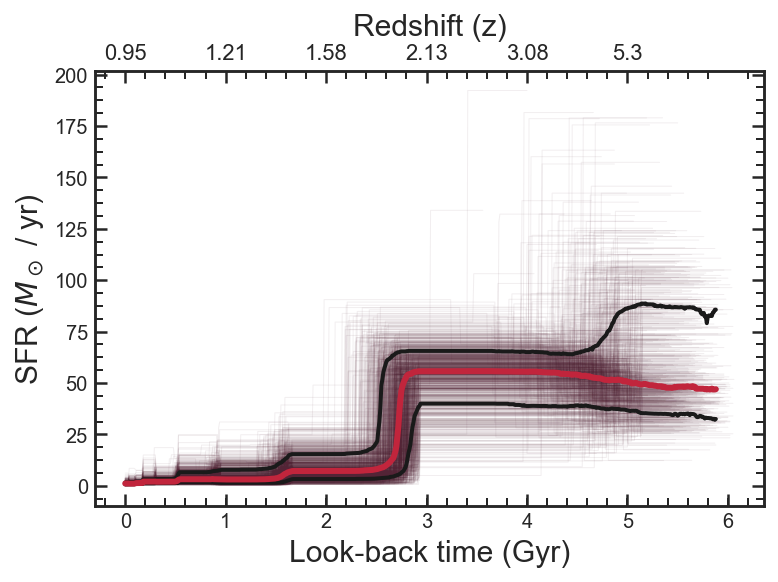

In [410]:
grow = mdb.query('id == 37813')

isfhl = interp1d(sfh.LBT,sfh.SFH_16)
isfhh = interp1d(sfh.LBT,sfh.SFH_84)

ax1 = plt.subplot()
ax2 = ax1.twiny()

ax1.plot(sfh.fulltimes, sfh.sfr_grid.T, color = '#532436', alpha=.075, linewidth = 0.5)
ax1.plot(sfh.LBT,sfh.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
ax1.plot(sfh.LBT,sfh.SFH_16, 'k', linewidth = 2)
ax1.plot(sfh.LBT,sfh.SFH_84, 'k', linewidth = 2)

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.arange(0,int(sfh.fulltimes[-1])))
ax2.set_xticklabels(np.round(lbt_to_z(np.arange(0,int(sfh.fulltimes[-1])) + cosmo.lookback_time(grow.zgrism.values[0]).value),2))
ax2.xaxis.set_ticks_position('top')

ax1.set_xlabel('Look-back time (Gyr)', fontsize=15)
ax1.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=15)
ax2.set_xlabel('Redshift (z)', fontsize=15) 
ax1.tick_params(axis='both', which='major', labelsize=10)
plt.savefig('../plots/GND_37813_all_sfh.png',bbox_inches = 'tight')

# ax1.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = '#ED2D39', linewidth = 2, zorder = 11)
# ax1.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = 'k', linewidth = 4, zorder = 10)

# for i in range(len(grow.t_50_hci.values[0])//2):
#     hdr = np.linspace(grow.t_50_hci.values[0][2*i],grow.t_50_hci.values[0][2*i+1])

#     ax1.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = '#4E7577', alpha=0.75, zorder = 8)
#     ax1.vlines(grow.t_50_hci.values[0][2*i],isfhl(grow.t_50_hci.values[0][2*i]),isfhh(grow.t_50_hci.values[0][2*i]), 
#                color = 'k', linewidth = 1, zorder = 8)
#     ax1.vlines(grow.t_50_hci.values[0][2*i+1],isfhl(grow.t_50_hci.values[0][2*i+1]),isfhh(grow.t_50_hci.values[0][2*i+1]), 
#                color = 'k', linewidth = 1, zorder = 8)

# ax1.vlines(grow.t_q.values[0],isfhl(grow.t_q.values[0]),isfhh(grow.t_q.values[0]), color = '#4E7577', linewidth = 2, zorder = 11)
# ax1.vlines(grow.t_q.values[0],isfhl(grow.t_q.values[0]),isfhh(grow.t_q.values[0]), color = 'k', linewidth = 4, zorder = 10)

# for i in range(len(grow.t_q_hci.values[0])//2):
#     hdr = np.linspace(grow.t_q_hci.values[0][2*i],grow.t_q_hci.values[0][2*i+1])

#     ax1.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = 'k', alpha=0.6, zorder = 8)
#     ax1.vlines(grow.t_q_hci.values[0][2*i],isfhl(grow.t_q_hci.values[0][2*i]),isfhh(grow.t_q_hci.values[0][2*i]), 
#                color = 'k', linewidth = 1, zorder = 8)
#     ax1.vlines(grow.t_q_hci.values[0][2*i+1],isfhl(grow.t_q_hci.values[0][2*i+1]),isfhh(grow.t_q_hci.values[0][2*i+1]), 
#                color = 'k', linewidth = 1, zorder = 8)

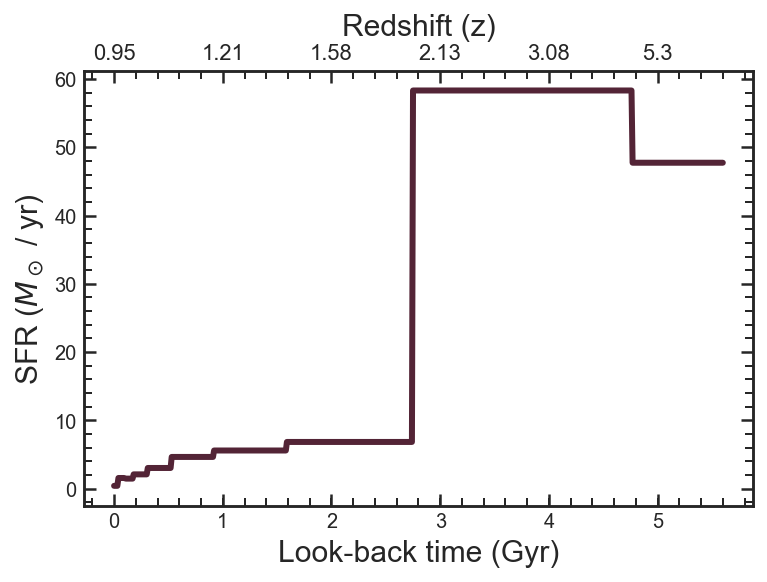

In [407]:
ax1 = plt.subplot()
ax2 = ax1.twiny()

ax1.plot(sfh.fulltimes, sfh.sfr_grid[0], color = '#532436', linewidth = 3)

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.arange(0,int(sfh.fulltimes[-1])))
ax2.set_xticklabels(np.round(lbt_to_z(np.arange(0,int(sfh.fulltimes[-1])) + cosmo.lookback_time(grow.zgrism.values[0]).value),2))
ax2.xaxis.set_ticks_position('top')

ax1.set_xlabel('Look-back time (Gyr)', fontsize=15)
ax1.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=15)
ax2.set_xlabel('Redshift (z)', fontsize=15) 
ax1.tick_params(axis='both', which='major', labelsize=10)
plt.savefig('../plots/GND_37813_single_sfh.png',bbox_inches = 'tight')


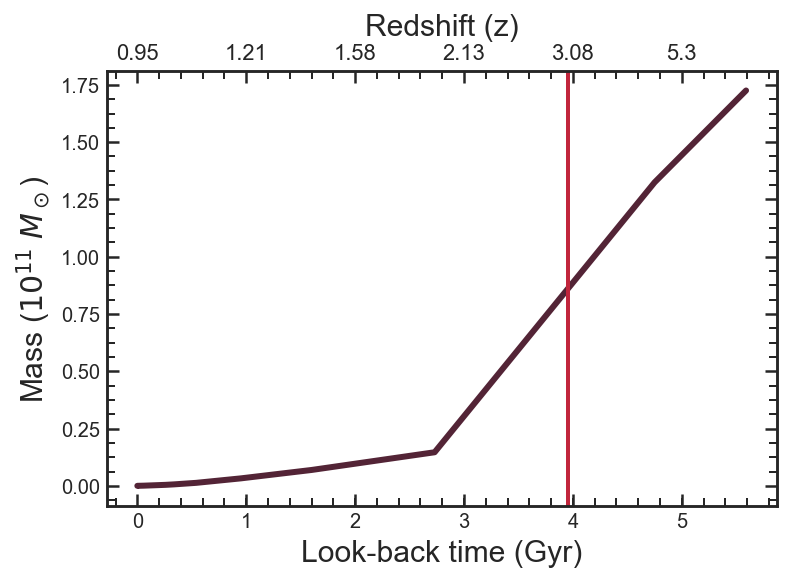

In [408]:
T=[0]
M=[0]
for i in range(len(sfh.fulltimes)-1):
    mass = sfh.sfr_grid[0][i+1] * (sfh.fulltimes[i+1] - sfh.fulltimes[i])
    if mass > 0:
        M.append(M[i] + mass)
        T.append(sfh.fulltimes[i])
    
t_50=interp1d(M/ M[-1], T)(0.5)

ax1 = plt.subplot()
ax2 = ax1.twiny()

ax1.plot(T, np.array(M)/100, color = '#532436', linewidth =3)
ax1.axvline(t_50,color = '#C1253C', linewidth =2)

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.arange(0,int(sfh.fulltimes[-1])))
ax2.set_xticklabels(np.round(lbt_to_z(np.arange(0,int(sfh.fulltimes[-1])) + cosmo.lookback_time(grow.zgrism.values[0]).value),2))
ax2.xaxis.set_ticks_position('top')

ax1.set_xlabel('Look-back time (Gyr)', fontsize=15)
ax1.set_ylabel('Mass ($10^{11}$ $M_\odot$)', fontsize=15)
ax2.set_xlabel('Redshift (z)', fontsize=15) 
ax1.tick_params(axis='both', which='major', labelsize=10)
plt.savefig('../plots/GND_37813_single_mass.png',bbox_inches = 'tight')


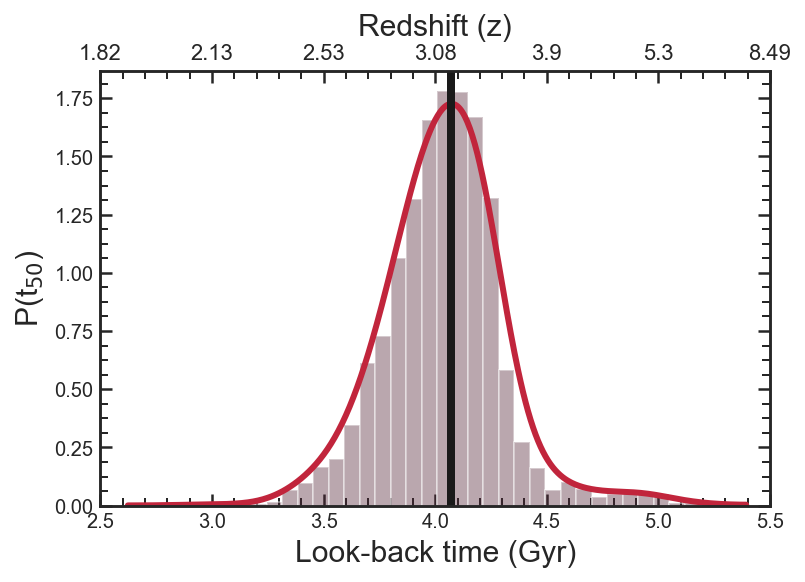

In [67]:
grow = mdb.query('id == 37813')

ax1 = plt.subplot()
ax2 = ax1.twiny()

sea.distplot(sfh.t_50_grid, hist_kws={'weights': sfh.weights}, kde=False, color = '#532436', norm_hist=True, bins=40, ax = ax1)
ax1.plot(x,np.array(px)*1.07 ,color = '#C1253C', linewidth = 3)
ax1.axvline(sfh.t_50,color = 'k', linewidth=4)
ax1.set_xlim(2.5,5.5)
ax2.set_xticks(np.arange(7))
ax2.set_xticklabels(np.round(lbt_to_z(np.arange(2.5,6.0,0.5) + cosmo.lookback_time(grow.zgrism.values[0]).value),2))
ax2.xaxis.set_ticks_position('top')

ax1.set_xlabel('Look-back time (Gyr)', fontsize=15)
ax1.set_ylabel('P(t$_{50}$)', fontsize=15)
ax2.set_xlabel('Redshift (z)', fontsize=15) 
ax1.tick_params(axis='both', which='major', labelsize=10)
plt.savefig('../plots/GND_37813_z_50.png',bbox_inches = 'tight')


In [60]:
sfh.z_50, sfh.t_50,np.arange(2.5,6.0,0.5)

(array(3.17263358),
 4.071991551884423,
 array([2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5]))

In [58]:
np.round(lbt_to_z(np.arange(2.5,6.0,0.5) + cosmo.lookback_time(grow.zgrism.values[0]).value),2)

array([1.82, 2.13, 2.53, 3.08, 3.9 , 5.3 , 8.49])

In [57]:
age_to_z(Oldest_galaxy(grow.zgrism.values[0]) - np.arange(2.5,5.5,0.5)), age_to_z(Oldest_galaxy(grow.zgrism.values[0]) - sfh.t_50), 

(array([1.8223851 , 2.12754416, 2.52601124, 3.07533669, 3.89660369,
        5.30265061]), array(3.17260425))

In [24]:
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

def boot_to_posterior(values, weights):
    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(values, q, weights=weights)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(values, bins=bins, weights=weights,range=np.sort(span))
    n = norm_kde(n, 20.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

x,px = boot_to_posterior(sfh.t_50_grid, sfh.weights)

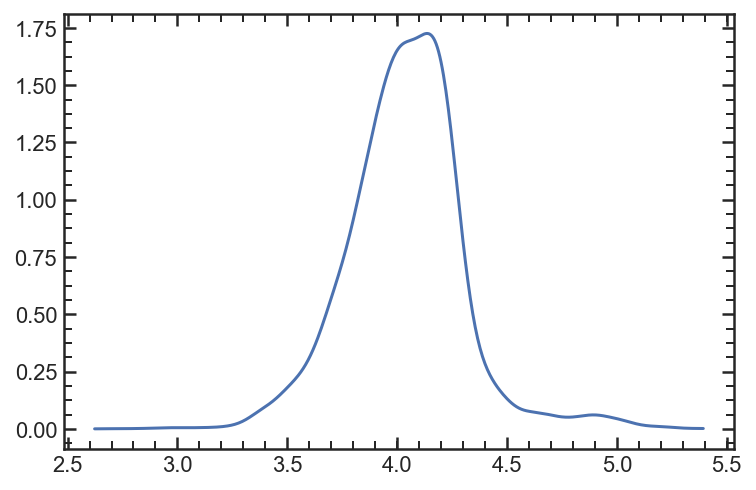

In [15]:
plt.plot(x,px)